# **CLASIFICADOR DEVANAGARI**

# **NOMBRE DE LOS AUTORES:**

1. César Alberto Mayora Suárez
2. Lucas Martín García

# **BASE DE DATOS SELECCIONADA**
13. Devanagari Handwritten Dataset

>Aclaración inicial: Debido al alto coste computacional de los modelos al entrenarse con el conjutno de datos, este documento tarda entre 15 y 20 minutos en ejecutarse completamente, pero no se queda nunca ejecutando indefinidamente, y los resultados del principio aparecen a medida que se ejecutan para poder ir visualizándose mientras que se ejecuta el resto (en el caso de que se quiera volver a ejecutar el documento).

In [5]:
'''
Como digerir el archivo .npz
- Localizar el archivo localmente, desde Google Drive o bajarlo desde Internet
- Utilizar `numpy.load` para obtener los arrays:
```
data = np.load("/path/to/data.npz")
```
- Obtener los arrays mediante acceso al diccionario de `data`de la siguiente manera:
```
X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']
```

'''

# TODO: realizar la descarga de estos archivos y su respectiva separacion en training y test
# propia si lo requiere, o sino dejarlo asi y solo descargar los archivos
# Más adelante se realiza la inclusión del archivo con los datos en el código

'\nComo digerir el archivo .npz\n- Localizar el archivo localmente, desde Google Drive o bajarlo desde Internet\n- Utilizar `numpy.load` para obtener los arrays:\n```\ndata = np.load("/path/to/data.npz")\n```\n- Obtener los arrays mediante acceso al diccionario de `data`de la siguiente manera:\n```\nX_train, y_train = data[\'X_train\'], data[\'y_train\']\nX_test, y_test = data[\'X_test\'], data[\'y_test\']\n```\n\nNOTA: La separacion de training y test es la misma que la que viene por defecto en la\ndescarga del repositorio de la UCI: https://consigna.ugr.es/?s=download&token=443be550-94ee-48dc-9ca4-5d797aa349d7\n'

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.base import clone
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, log_loss, hinge_loss, make_scorer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from skimage import feature
from skimage import io


#Para acceder a nuestros ficheros de Google Drive
from google.colab import drive

drive.mount('/content/drive')
# La carpeta datos (que contiene X_train.npy, y_train.npy, X_test.npy y y_test.npy)
# debe estar en vuestro Drive, dentro de la carpeta 'Colab Notebooks'

# Establecemos la semilla del RNG
np.random.seed(33)

# Mapeo de clases a etiquetas (SOLO PARA FUTURAS REFERENCIAS)
map_labels = {
	'character_1_ka': 0,
	'character_2_kha': 1,
	'character_3_ga': 2,
	'character_4_gha': 3,
	'character_5_kna': 4,
	'character_6_cha': 5,
	'character_7_chha': 6,
	'character_8_ja': 7,
	'character_9_jha': 8,
	'character_10_yna': 9,
	'character_11_taamatar': 10,
	'character_12_thaa': 11,
	'character_13_daa': 12,
	'character_14_dhaa': 13,
	'character_15_adna': 14,
	'character_16_tabala': 15,
	'character_17_tha': 16,
	'character_18_da': 17,
	'character_19_dha': 18,
	'character_20_na': 19,
	'character_21_pa': 20,
	'character_22_pha': 21,
	'character_23_ba': 22,
	'character_24_bha': 23,
	'character_25_ma': 24,
	'character_26_yaw': 25,
	'character_27_ra': 26,
	'character_28_la': 27,
	'character_29_waw': 28,
	'character_30_motosaw': 29,
	'character_31_petchiryakha': 30,
	'character_32_patalosaw': 31,
	'character_33_ha': 32,
	'character_34_chhya': 33,
	'character_35_tra': 34,
	'character_36_gya': 35,
    'digit_0': 36,
    'digit_1': 37,
    'digit_2': 38,
    'digit_3': 39,
    'digit_4': 40,
    'digit_5': 41,
    'digit_6': 42,
    'digit_7': 43,
    'digit_8': 44,
    'digit_9': 45,
}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **COMIENZO DEL PROYECTO**

## Descripción y planteamiento del problema

Planteamos un problema de clasificación donde se desea construir un sistema de clasificación de caracteres manuscritos del sistema de escritura _**Devanagari**_ o _Devanāgarī_ (ver Figura 1), formalmente descrito como un _Abugida_ o pseudo-alfabeto que consta de $46$ caracteres (en nuestro caso) y es el sistema oficial de escritura en países como la India y Nepal.

Nuestro objetivo es poder diseñar y entrenar un modelo de Machine Learning que mejor reconozca o clasifique estos caracteres manuscritos de forma individual (clasificar un caracter dado).

![devanagari_1](http://luc.devroye.org/DevanagariAlphabet-1933.png)

_[Figura 1](http://luc.devroye.org/DevanagariAlphabet-1933.png): Ejemplo de caracteres del sistema Devanagari_

### Datos disponibles

Contamos con un conjunto de datos o _dataset_ de dominio público y que podemos encontrar en el repositorio de la UCI (*). Este _dataset_ cuenta con una serie de imágenes en formato PNG etiquetadas con una resolución de $32 \times 32$ píxeles en escala de grises, es decir, cada píxel de una imágen tendrá un valor entre $[0,255]$, donde $0$ indica un color negro mientras que $255$ indica un color blanco.

Disponemos de un total de $92000$ imágenes o ejemplos en nuestro conjunto de datos y de $46$ clases con $2000$ ejemplos cada una. El _dataset_ viene dividido por defecto en dos conjuntos de datos: uno de training y uno de test con un $85\%$ y un $15\%$ de los ejemplos totales respectivamente.

### Objetivo propuesto

Nuestro objetivo es poder diseñar y entrenar un modelo de Machine Learning a partir de nuestros datos disponibles usando un conjunto de entrenamiento (training) para el aprendizaje y selección del mejor modelo de clasificación y un conjunto de test para la evaluación del modelo final. Buscamos obtener el mejor modelo de clasificación que maximice la precisión (_accuracy_) en la clasificación de estas imágenes.

Para ello, consideraremos un modelo lineal y dos modelos no lineales, y mediante una proceso de selección de modelos o _model selection_, compararemos y elegiremos el mejor modelo de clasificación para nuestro problema, evaluándo su rendimiento final con el conjunto de test.

### Descripción formal del problema

Describimos formalmente nuestro problema identificando sus principales componentes. En primer lugar, disponemos de un conjunto de datos (o secuencia de datos) $\mathcal D$ que está compuesta por una secuencia de ejemplos de la forma $(\text{x}_1, y_1), ..., (\text{x}_N, y_N)$, donde $\text{x}_n$ es un vector de características que definen a un caracter (imágen) concreto, e $y_n$ representa el respectivo nombre del caracter (etiqueta).

Definimos el espacio de entrada como $\mathcal X = ℝ^d$ como un espacio $d$-dimensional de valores reales, en nuestro caso, cada píxel de entrada de una imágen está definido por números enteros en $ℕ$ pero nos conviene usar valores reales en este caso ya que probablemente estos valores pueden ser modificados o transformados y necesitamos que el espacio de entrada extrapole a un espacio real; en todo caso como $ℕ ⊂ ℝ$, nos es válido.

Definimos el espacio de salida $\mathcal Y = \{0, 1, ..., 45\}$ donde cada etiqueta $y_i \in \mathcal Y$ representa una clase de nuestro problema $C_{i}$. Cada clase corresponde al nombre de cada caracter de nuestro conjunto de datos:
$$C_0 = \textit{"ka"}, C_1 = \textit{"kha"}, C_2=\textit{"ga"}, ...$$

Definimos nuestra función objetivo $f: \mathcal X → \mathcal Y$ que es la función que perfecta y exactamente clasifica los ejemplos de la población y consecuentemente de nuestro conjunto de datos $\mathcal D$ asignando a cada ejemplo $\text{x}_n \in \mathcal X$ un valor en $y_n \in \mathcal Y$. Esta función es y será desconocida para nosotros y es la que intentaremos mediante el ajuste de un modelo de aprendizaje aproximar para clasificar lo mejor posible y con el mínimo error los datos de entrada.

> (*) Acharya,Shailesh and Gyawali,Prashnna. (2016). Devanagari Handwritten Character Dataset. UCI Machine Learning Repository. https://doi.org/10.24432/C5XS53.

## Definición de los conjuntos de hipótesis y modelos de aprendizaje usados

#### Clase de funciones $\mathcal H$-lineal -  Modelo lineal
Definimos entonces el conjunto de hipótesis que consideraremos en la construcción de nuestros modelos de aprendizaje. En primer lugar consideraremos un conjunto de hipótesis $\mathcal H$ lineal; para este problema de clasificación tomaremos la clase de funciones lineales más simple que consiste en una combinación lineal de los datos de entrada $\text{x}$ ponderados con un vector de pesos $\text{w} \in ℝ^{d+1}$, por tanto nuestras funciones hipótesis tendrán la forma

$$h(\text{x}) = w_0 + \sum_{j=1}^{d}{w_j x_j}$$

donde $w_0$ es el parámetro denominado _bias_, y que nos permite fijar una base en el modelo que puede influir en la aproximación a la función objetivo mediante el algoritmo de aprendizaje $\mathcal A$.

Para tener una notación más conveniente a lo largo de la solución a este problema, podemos fijar un parámetro en los datos de entrada $\text{x}$ para que multiplique a este _bias_, quedándonos de esta forma matricial más conveniente:

$$h(\text{x}) = \sum_{j=0}^{d}{w_j\phi_j(\text{x})} = \text{w}^T\phi(\text{x})$$

donde $\phi$ es una denominada _basis function_, que es una función que transforma los datos de entrada $\text{x}$; la razón por la cual es una conveniencia usar una _basis function_ es porque los datos de entrada durante el procesamiento de los datos sufren transformaciones, preprocesamiento previo o extracción de características (_feature extraction_), siendo luego estos datos preprocesados de los datos originales los que se usarán para la predicción y el aprendizaje del modelo; por tanto, todas las posibles transformaciones podemos expresarlas en términos de _basis functions_ $\{\phi_j(\text{x})\}$.

Nosotros también cambiaremos la notación de la combinación lineal $h(\text{x})$ a $s(\text{x})$ tratándola como una "señal" más que un predictor. Esto es porque los modelos que hacen uso de esta clase de hipótesis usan una función de predicción diferente que hace uso de esta señal. Sin embargo, hay que tener en cuenta que la clase de funciones de donde queremos obtener el mejor predictor $g$ es uno del tipo $g(\text{x}) = \text{w}^T\phi$, como antes habiamos mencionado, y es en esencia el modelo final de clasificación.

Con esta primera clase de funciones lineales podemos definir lo que será nuestro modelo lineal de clasificación, en nuestro caso hemos elegido el modelo de __Regresión Logística__ o RL que consiste en el aprendizaje de los pesos óptimos $\text{w}$ para calcular la __probabilidad__ de que un ejemplo pertenezca a una clase u otra, es decir, calcula un número en el rango $[0,1]$ que indica esta probabilidad. El clasificador RL se define de la siguiente manera:

$$h(\text{x}_i) = \theta(s(\text{x})) = \theta(\text{w}^T\phi(\text{x}_i))$$

donde $\theta$ es la denominada función logística (_logistic function_) que es una función no lineal aplicada a la combinación lineal de pesos y que asigna una probabilidad entre $[0,1]$. La función logística que usaremos será la función _sigmoide_ por ser una función ampliamente utilizada, es una función derivable y es una función que está acotada para sus valores extremos por lo que es facilmente interpretable en términos probabilísticos.

$$\sigma(s(\text{x}_n)) = \frac{1}{1 - e^{-s(\text{x}_n)}} \rightarrow
\begin{cases}
\ge 0.5 & y_n = +1 \\
\lt 0.5 & y_n = -1
\end{cases}$$

Nosotros elegimos RL como primer modelo ya que en general es bastante utilizado en problemas de clasificación y es conocido por ser uno de los mejores modelos de clasificación gracias a su fundamento probabilístico y por ser insensible al ruido, lo cual lo hace un buen clasificador cuando hay mucha presencia de ruido estocástico.

#### Modelos no lineales

A continuación definiremos dos modelos de clasificación no lineales. Estos modelos se consideran no lineales por ser capaces de capturar características o aspectos no lineales en los datos siendo modelos muy poderosos cuando hay mucha presencia de mucho ruido determinístico o cuando el dominio del problema es muy complejo; nosotros hemos elegido dos de ellos: __SVM-soft__ con kernel no lineal y __Perceptrón Multicapa__.

El primero de ellos, el modelo SVM-soft con kernel no lineal es un modelo que consiste en la optimización de pesos $\text{w}$ de nuestro modelo para conseguir el hiperplano óptimo que separe los ejemplos con el mayor márgen posible (_fat margin_). La función de clasificación del SVM se define muy similar a otros modelos como el Perceptrón que usan la función no lineal escalonada:

$$h(s(\text{x}_i)) = \text{sign}(s(\text{x}_i))$$

Como podemos ver, usa la función no lineal escalonada, que se interpreta como el "signo" de la señal:
$$h(s(\text{x}_i)) =
\begin{cases}
s(\text{x}_i) < 0 & y_n = -1 \\
s(\text{x}_i) > 0 & y_n = +1
\end{cases}
$$

Nosotros usamos la formalización _soft_ que quiere decir _soft margin_, que consiste en establecer una restricción $C$ correspondiente a la tolerancia de error de clasificación (ejemplos mal clasificados) que puede permitir el modelo. Por tanto, este modelo tratará de optimizar el siguiente problema, llamado el problema Primal:

$$\min_{b, \text{w}, \xi}{\frac{1}{2} \text{w}^T\text{w} + C\sum_{i=0}^{N}{\xi_i}} \\
\text{subject to:} \ \ y_n(\text{w}^T\text{x}_n + b) \ge 1 - \xi_n
$$

donde $b$ es el _bias_ y $\xi$ es el número de ejemplos mal clasificados. El modelo SVM-soft es un clasificador muy reconocido por ser un modelo que optimiza el mismo hiperplano para ser el mejor cuando generaliza fuera de la muestra ya que la maximización del márgen (_fat margin_) lleva implícita regularización, disminuyendo la dimensión VC del modelo, por lo que lo hace especialmente bueno cuando se enfrenta a datos que no ha visto antes.

Este modelo aunque use una clase de funciones lineal ($h(\text{x}) = \text{w}^T\phi(\text{x}))$), se considera un modelo no lineal al hacer uso de un kernel no lineal, puesto que estos kernels mapean los datos de entrada en $\mathcal X$ a un espacio de mayor dimensión $\mathcal Z$ donde puede encontrar el separador óptimo cuando los datos no son linealmente separables. En nuestro caso, usaremos el kernel __RBF-Gaussiano_, un kernel no lineal.

El último modelo que vamos a utilizar es un Perceptrón Multicapa (_Multilayer Perceptron_ o MLP) que es un tipo de Red Neuronal Artificial (ANN) que consiste en la combinación de múltiples modelos de Perceptrón organizadas en múltiples capas de neuronas completamente conectadas. Aunque el nombre haga referencia a usar modelos de Perceptrón, realmente puede comprender modelos lineales mucho más potentes como la Regresión Logística (RL), que involucra una función de activación no lineal $θ$. Nosotros usaremos este enfoque de MLP como un compendio de múltiples modelos de Regresión Logística organizados en una arquitectura de neuronas interconectadas.

MLP esta basado en una Red Neuronal de tipo _feed-forward_, en el que los datos de entrada entran por una capa de entrada y fluye sobre las capas sucesivas ocultas hasta una capa de salida.

El uso de diferentes neuronas interconectadas, en el que cada neurona es un modelo de Regresión Logística, es lo que hace que este modelo sea no lineal, ya que podemos usar múltiples modelos RL para combinar sus datos de salida y así poder aumentar la capacidad de clasificación y poder capturar un patrón subyaciente más complejo.

La función de predicción $h(\text{x})$ del MLP está definida por el algoritmo de propagación hacia adelante (_forward propagation_):

$$s^{(l)}_j = (\text{W}^{(l)})^T \text{x}^{(l-1)}$$

donde $\text{W}^{(l)}$ son todos los pesos en la capa $l$ y $\text{x}^{(l)}$ es la salida dada por la capa $\theta(s^{(l)})$

Luego, la función de predicción viene dada por aplicar el algoritmo de _forward propagation_ en la última capa $L$

$$h(\text{x}) = \theta(s^{(L)}) = \theta((\text{W}^{(L)})^T \text{x}^{(L-1)})$$

Ahora necesitamos definir la arquitectura de nuestra red que sería lo equivalente a fija una clase de funciones $\mathcal H_{nn}$. Nosotros usaremos una arquitectura de $L=3$ capas, es decir, una capa de entrada (_input layer_), $2$ capas ocultas (_hidden layer_) y una capa de salida (_output layer_). Cada capa $l$ tiene una dimensión $d(l)$, que quiere decir que en la capa $l$ hay $d(l)+1$ neuronas etiquetadas como $0,1,2,...,d(l)$ (la neurona $0$ es la neurona _bias_o sesgo). Para que nuestra arquitectura esté bien definida debemos de asignar la dimensión a cada capa $l$ de nuestra red, sin embargo, este parámetro puede influir en gran medida, pues a mayor dimensión por capa, estamos aumentando la complejidad de $\mathcal H_{nn}$ lo que puede resultar en sobreajuste, por tanto, nos sería conveniente tratar $d(l)$ para cada capa $l$ como un hiperparámetro del modelo. Como tenemos aún así que definir $\mathcal H_{nn}$ podemos establecer un rango de valores para esta dimensión como un rango que varía entre $50$ y $100$, de esta manera definimos un conjunto de hipótesis aproximado.

También tenemos que definir, luego de establecer la arquitectura de la red, las funciones de activación $\theta$ de cada neurona, que son las que definen las _basis functions_ de cada neurona, como MLP aprende estas los parámetros de estas funciones (que son los pesos y el _bias_), tendremos que prefijar estas funciones de activación antes de entrenar nuestro modelo. Nosotros optaremos por la función ReLU (Rectified Linear Unit) $f(\text{x}) = θ(\text{w}^T\phi(\text{x})) = ReLU(\text{w}^T\phi(\text{x}))$ para cada neurona. Elegimos esta función porque tiene una ventaja a nivel de eficiencia computacional por no usar cálculos exponenciales como en el caso de la sigmoide, y porque activa las neuronas cuyo valor es positivo, por lo que promueve la dispersión de las características en la red y capturar mejor las relaciones no lineales al solo tomar en cuenta las neuronas relevantes, a diferencia de las funciones sigmoide y tangente hiperbólica que toma en cuenta valores negativos que realmente solo dan redundancia en la red.

## Función de perdida y métricas de error

#### Métricas de error
A continuación vamos a definir cuales son las métricas de error a usar en este problema de clasificación así como decir para cada una que información nos aporta.

Las métricas que usaremos son por una parte, sacadas de la matriz de confusión, y otras, son específicas para problemas de clasificación multietiqueta. La matriz de confusión es una herramienta muy usada en Machine Learning para evaluar el rendimiento de un modelo de ML. Se suele usar mayoritariamente en problemas de clasificación y tiene una estructura tabular y que compara la frecuencia de clases predichas por el modelo y su valor real.

![](https://dataaspirant.com/3_confusion_matrix/)
_Figura tomada de https://dataaspirant.com/wp-content/uploads/2020/08/3_confusion_matrix.png_

A partir de la matriz de confusión se pueden calcular métricas para evaluar un modelo de clasificación. Entre ellas se encuentran las que usaremos que son:

- _Accuracy_ o exactitud: nos permite medir su tasa de clasificación correcta, es decir, la fracción de ejemplos que ha clasificado correctamente (independientemente de su clase). Se calcula como:
$$\frac{TP + TN}{TP + TN + FP + FN}$$
- _Specificity_ o especificidad: Mide la fracción de las muestras que han sido clasificadas como negativas y que realmente fueron negativas, es decir, nos da una métrica para medir que tan bien clasifica la clase negativa. Se calcula como:
$$\frac{TN}{TN + FP}$$
- F1-Score: Esta métrica combina dos métricas denominadas _Recall_ y _Precision_ en un valor único, y es especialmente útil cuando queremos encontrar un equilibrio entre los falsos positivos y falsos negativos. Se calcula como:
$$\frac{2\cdot (\text{Precision}\cdot \text{Recall})}{(\text{Precision}+ \text{Recall})}$$

Como podemos observar, estamos eligiendo las métricas que nos pueden dar una mejor percepción global del rendimiento de un modelo. Si observamos por un lado la _Accuracy_ no engloba la tasa de clasificación correcta de nuestro modelo, es decir, que tanto nuestro modelo acierta en proporción, esta métrica se considera de las más importantes porque es la que más engloba el rendimiento de un clasificador sin importar la clase que esta prediciendo. Sin embargo, es por esta generalidad de la _Accuracy_ que por sí sola no podemos utilizar para evaluar un modelo frente a otros, sobre todo cuando hay clases desbalanceadas, ya que podemos construir un clasificador con _Accuracy_ de un $80\%$ pero en un conjunto de datos que tiene un $80\%$ de desbalanceo, luego un clasificador que prediga con la media, consigue la misma _accuracy_.

Para abordar el problema de usar solo la _accuracy_ tenemos que evaluar el rendimiento del clasificador tanto con la clase negativa como la positiva. En este caso utilizamos por un lado F1-Score que especialmente útil en estos casos de desbalanceo de etiquetas, ya que se considera un métrica muy robusta que balancea el peso de la clase menos representada realizando la media armónica del _Recall_ y de la _Precision_. Sin embargo, el _Recall_ y la _Precision_ solo tienen en cuenta la clase positiva y ahí es donde entra la última métrica, la _Specificity_ que mide que tan bien clasifica la clase negativa, completando el cálculo del rendimiento de un modelo.

Con estas métricas seremos capaces de elegir de forma sensata y con bastante criterio aquel modelo que mejor clasifica una muestra de datos. He de decir, que cada métrica puede ser ponderada de manera que le demos más importancia a una que de otra, esto por supuesto depende del problema concreto a tratar y que estudiaremos más a detalle cuando definamos el _scorer_ que usaremos para realizar el _ranking_ que nos elegirá el mejor modelo.

#### Funciones de perdida

Nos queda por definir las funciones de perdida para nuestros modelos de clasificación. Empezaremos por la función de perdida para Regresión Logística que será la función de Entropía Cruzada o _cross entropy_ definida por:

$$E(\text{w}) = \frac{1}{N}\sum_{n=0}^{N}{\ln{(1 - e^{-y_n\text{w}^T\text{x}_n})}}$$

Esta función, también denominada como función de perdida logística, es ampliamente usada por estar basada en la probabilidad de semejanza o _likelihood_ de un ejemplo según la distribución de probabilidad que se captura de la muestra. Definida la función de perdida para Regresión Logística definimos el algoritmo de aprendizaje $\mathcal A$ que emplearemos para aprender los pesos que minimizan esta función de perdida, usaremos en nuestro caso el algoritmo de _Stochastic Gradient Descent_ o Descenso del Gradiente Estocástico. La elección de este algoritmo viene dado a que es un algoritmo que tiene un buen rendimiento con datasets de gran tamaño, ya que es un algoritmo muy rápido al usar un tamaño de muestra de $1$ ejemplo por cada iteración, además, es un algoritmo muy flexible que da mucho juego en cuanto a parametrización y parametros de regularización (L1, L2, $\eta$, tamaño de minibatch, etc).

La función de perdida que usaremos para el modelo de SVM-soft será la función de perdida de bisagra o _hinge loss_ modificada para la formulación _soft_ de SVM, que es una función que penaliza los errores en clasificación permitiendo un cierto márgen de error y que se define como:

$$E(\text{w}) = \max{(0, 1-y_n\text{w}^T\text{x}_n)} + C\sum_{n=0}^{N}{\xi_n}$$

donde $C$ es un parámetro de penalización de los errores $\xi_n$ cometidos por el márgen. La elección de esta función de perdida, además de por ser la más usada para el entrenamiento de clasificadores SVM, es porque es una función que conduce a una mejor presición ya que penaliza los errores de clasificación como hemos dicho y por tanto es ideal por si queremos un clasificador donde podamos controlar márgenes de error de una forma más restrictiva. Definida la función de perdida en SVM, ahora definiremos el algoritmo de aprendizaje $\mathcal A$ para aprender los pesos que minimizan la función de perdida, la cual será un algoritmo de programación cuadrática que optimiza multiplicadores de Lagrange que definen los vectores soporte que definen el márgen final.

En cuanto al modelo MLP, la función de perdida es la media de los errores cometidos por las neuronas:

$$E(\text{w}) = \frac{1}{N}\sum_{n=1}^{N}{\text{e}_n}$$

El error de cada neurona depende de la arquitectura de nuestra red, en nuestro caso cada neurona corresponde a un modelo de RL, que sabemos que calcula un valor probabilístico que corresponde a la máxima _semejanza_ o _likelihood_ de que un ejemplo pertenzca a una clase u otra. En efecto estamos tratando de aprender la distribución de probabilidad de la muestra, concretamente dado un conjunto de datos de entrada $\text{X} = \{\text{x}_1, ..., \text{x}_N\}$ y sus clases $\text{y} = \{y_1, ..., y_N\}$ la función de _likelihood_ de la muestra es:

$$ℙ(\text{y} | \text{X}, \text{w}) = ∏_{n=1}^{N}{ℙ(y_n | \text{x}_n, \text{w})}$$

A partir de esto, podemos obtener los valores de $\text{w}$ que maximicen el _likelihood_, para obtener una función de perdida que minimizar, podemos considerar la minimización de la función de suma de cuadrados medio que es equivalente a maximizar el _likelihood_, de esta manera obtenemos la función de perdida para cada neurona se define como
$$\text{e}(h_{RL}, y) = \frac{1}{N}\sum_{n=1}^{N}{(y_n - h_{RL}(\text{w}, \text{x}))^2}$$

siendo $h_{RL}$ la función de predicción del modelo de Regresión Logística que tiene el mismo diseño que el especificado en nuestro modelo lineal de Regresión Logística de nuestro conjunto de modelos para el problema (esta vez usando la función de activación $ReLU(s)$ en vez de la sigmoide).

> (1) Bishop, Christopher M. Pattern Recognition and Machine Learning. New York :Springer, 2006


## Obtención de los datos

Antes de poder empezar a realizar el preprocesamiento de los datos y el aprendizaje de nuestros modelo, primero debemos de obtenerlos.

Los datos originalmente se estructuran como una matriz 32x32 de valores numéricos para cada muestra, que representan todos los píxeles de la imagen.

In [7]:
data = np.load("drive/MyDrive/Colab Notebooks/dataset.npz")
X_train_original, Y_train_original = data['X_train'], data['y_train']
X_test_original, Y_test_original = data['X_test'], data['y_test']
print("Forma de vector X de entrenamiento de muestras:",X_train_original.shape)
print("Forma de vector Y de entrenamiento de muestras:",Y_train_original.shape)
print("Forma de vector X de test de muestras:",X_test_original.shape)
print("Forma de vector Y de test de muestras:",Y_test_original.shape)

Forma de vector X de entrenamiento de muestras: (78200, 32, 32)
Forma de vector Y de entrenamiento de muestras: (78200,)
Forma de vector X de test de muestras: (13800, 32, 32)
Forma de vector Y de test de muestras: (13800,)


Inicialmente la base de datos se separa en un conjunto para entrenamiento (train) y otro para test, entonces vamos a unir todo el conjunto de datos para poder hacer nuestra propia separación en train y test valorando el porcentaje que queremos que tenga cada parte.

In [8]:
X_original = np.row_stack((X_train_original,X_test_original))
Y_original = np.concatenate((Y_train_original,Y_test_original))
print("Forma de vector X del conjunto total de muestras:",X_original.shape)
print("Forma de vector Y del conjunto total de etiquetas:",Y_original.shape)

Forma de vector X del conjunto total de muestras: (92000, 32, 32)
Forma de vector Y del conjunto total de etiquetas: (92000,)


Vamos a transformar la forma de los datos de cada muestra de matriz 32x32 a un único vector con todos los píxeles de la muestra.

In [9]:
X_total = X_original.reshape(len(X_original), -1)
Y_total = Y_original.copy()
print("Forma de vector X del conjunto total de muestras:",X_total.shape)
print("Forma de vector Y del conjunto total de etiquetas:",Y_total.shape)

Forma de vector X del conjunto total de muestras: (92000, 1024)
Forma de vector Y del conjunto total de etiquetas: (92000,)


Vamos a modificar el vector de etiquetas ya que inicialmente cada etiqueta se representa como un número
$y_i \in \{0, 1, ..., 45\}$, y por tanto vamos a transformar estas etiquetas al espacio de salida $\mathcal Y$ donde cada etiqueta $y_i \in \mathcal Y$ identifica una clase de nuestro problema $C_{i}$ y es representado por un vecotor de 46 valores binarios donde todos los valores del vector toman el valor 0 excepto el valor en la posición $i$ que toma el valor 1 representando que la etiqueta es la clase $ i \in \{0,1,2,3...45\}$.

Para ello aplicamos One-Hot encoding a las etiquetas empleando la clase OneHotEncoder utilizando los siguiente parámetros para crear el objeto codificado:
*   categories: se especifica la lista categ que contiene las categorías de cada variable.
*   sparse_output=False: se establece en False para obtener una matriz densa en lugar de una matriz dispersa, para obtener una matriz con las columnas de cada nueva variable unificadas para añadirlas directamente al conjunto de datos.
*   drop=None: se establece en None para mantener todas las categorías en cada variable.
Después se utiliza el método fit_transform del objeto codificador para realizar la codificación One-Hot de las variables categóricas elegidas.


En algunos modelos implementados de la libreria `sklearn`, la clase implementa la codificación de las etiquetas internamente como un paso mas del proceso de ajuste del modelo, por lo tanto vamos a guardar el vector de etiquetas como estaba originalmente también para estos casos.

In [10]:
# Etiquetas del 0 al 45 incluido
categorias =  [np.arange(46)]

# Reshape del vector de etiquetas a una matriz columna para aplicar el codificador al vector
Y_total_reshaped = Y_total.reshape(-1, 1)

#Funcion para codificar
encoder = OneHotEncoder(
     categories=categorias,  # Categorías de cada variable
     sparse_output=False,  # crea una matriz sparse cuando se pone TRUE
     drop  = None  #  No quitar categorías en cada variable
     )

Y_total_OneHot = encoder.fit_transform(Y_total_reshaped) # Aplicar One Hot Encoding al conjunto total
print("Forma de vector Y del conjunto total de etiquetas:",Y_total.shape)

Forma de vector Y del conjunto total de etiquetas: (92000,)


Ahora cada etiqueta se representa como un vector de 46 valores binarios.

Hemos aplicado esta transformación ya que utilizar valores enteros de 0 a 45 para representar las etiquetas puede causar problemas, ya que los algoritmos pueden interpretar que hay un orden o relación numérica entre las etiquetas. El One Hot Encoding proporciona una representación binaria explícita que evita asociar relaciones entre las clases.

Después de obtener el conjunto total de datos separamos los datos en un conjunto de entrenamiento y otro de test. Realizamos esto lo primero para evitar observar los datos de test y realizar "Data Snooping" donde el conjunto de datos podría influenciar nuestra elección sobre el modelo a utilizar para resolver el problema de aprendizaje automático. Para separar las muestras en train y test, dos distribuciones muy comunes en la práctica son 70% de train y 30% de test, y 80% de train y 20% de test. Al utilizar una distribución 70-30 obtendríamos una estimación mejor del error $E_{out}$ a partir del error $E_{test}$ que con la de 80-20, ya que se utilizaría un número mayor de muestras para obtener la estimación, un 30% del total, que en la otra distribución que usaría un 20% del total. Sin embargo, al utilizar una distribución 80-20 obtendríamos un mejor ajuste del problema al entrenar el modelo de aprendizaje con más datos que con la otra distribución, teniendo una mejor generalización en el conjunto de entrenamiento de la función que tratamos de aproximar. En general cuantos más datos se utilicen en test mejor será la estimación del error  $E_{out}$ y cuantos más datos se utilicen en el entrenamiento, el clasificador calculado se ajustará mejor al problema, ya que tiene más datos con los que aprender.
En este caso he elegido una distribución de 80% para entrenamiento y 20% de test, teniendo en cuenta que con esta distribución se tiene un número menor de datos para estimar el error  $E_{out}$, pero se tiene un número mayor de datos para entrenar y para utilizar Cross-Validation con un conjunto de datos mayor.

In [11]:
trainPortion = 0.7 #porcentaje de train, el porcentaje de test será la resta de 1 menos el porcentaje de train

#-------------Obtener índices

indexesData = np.arange(len(Y_total)) #Indices del conjunto de muestras
#-------------Desordenar indices y separar en rain y test

np.random.shuffle(indexesData) #Desordenar indices de las muestras
numberTrain = round(len(indexesData)*trainPortion) #numero de muestras para train
trainIndexes = indexesData[:numberTrain]
testIndexes = indexesData[numberTrain:]

#-------------Datos desorden:ados para train y test

X_train = X_total[trainIndexes]
X_test = X_total[testIndexes]
Y_train = Y_total[trainIndexes]
Y_test = Y_total[testIndexes]

#-------------Copia de los datos para mantener datos originales después del preprocesado

original_trainX = X_train.copy()
original_testX = X_test.copy()
original_trainY = Y_train.copy()
original_testY = Y_test.copy()

#-------------Mostrar resultados

print('Muestras totales:  {}'.format(len(Y_train)+len(Y_test)))
print('Muestras train:  {}'.format(len(Y_train)))
print('Muestras test:  {}'.format(len(Y_test)))


Muestras totales:  92000
Muestras train:  64400
Muestras test:  27600


Se podría utilizar la función `train_test_split()` de scikit-learn que ofrece un comportamiento similar al código implementado. Como podemos observar, tenemos un total de 92000 muestras, de los cuales 73600 , que representan el 80% del total, serán utilizados para entrenamiento y el resto 18400 (20% del total) para test.

## Transformaciones y preprocesado de los datos de entrada

Teniendo el problema planteado, pasaremos a realizar un preprocesado inicial de los datos, esto es transformaciones sobre los datos originales $\text{x}$ que son previos a posterior entrenamiento y validación de los datos.

#### Normalización/Escalado de los datos de entrada

En nuestro caso haremos una primera transformación que se denomina un escalado de los datos o normalización de los datos. El escalado consiste en establecer un mapeo de los valores de cada atributo a un rango de valores concreto y común entre todos los atributos. La normalización de los atributos es una práctica muy común en Machine Learning y en ciencia de datos ya que:
- Permite un entrenamiento más estable en el sentido de que al realizar el proceso de optimización o aprendizaje de los pesos, al tener un rango de valores más pequeño restringe el espacio de búsqueda de los pesos lo que puede evitar problemas como un _estancamiento del gradiente_ que esta presente sobre todo en redes neuronales.
- Permite un entrenamiento más rápido en converger a una solución, esto se debe a que evita desbordamientos de los valores de los pesos, como puede ser el caso de un dato de entrada que sea muy grande y el peso que pondera este dato (dependiendo de su valor inicial) puede tardar mucho en poder converger con este dato.

Aunque en nuestro caso, los valores de los píxeles están en un rango cerrado $[0,255]$, un escalado de los datos nos ayudará a mejorar el rendimiento del aprendizaje. En nuestro caso optaremos por una normalización _Min-Max_ también denominado _reescalado_, que se formula de la siguiente forma:
$$z_j = \frac{x_j - \min{(x_j)}}{\max{(x_j) - \min{(x_j)}}}$$

Es importante notar, que el escalado que hagamos en training debe ser el mismo escalado que se hará en test, esto es usar el mismo máximo y el mismo mínimo que en training para test; esto es para que el escalado en test vaya acorde con lo que aprendió el modelo que son valores escalados en training, y no haya una interpretación errónea de los resultados. Sin embargo, esto no es probable que pase, ya que los valores de los píxeles son fijados en un rango concreto $[0,255]$, por tanto, es muy improbable que ocurra que en test no haya un mínimo en $0$ o un máximo en $255$, en todo caso, para estar seguros guardaremos los máximos y los mínimos de los atributos en training como constantes para su posterior uso.

> En el caso de que hayan columnas con solo valores $0$, como puede ser las esquinas de las imágenes, entonces le asignamos un valor de cero (ignoramos normalizar estas columnas)

In [12]:
# Definimos una función que abstrae este proceso para un conjunto de features
# con valores concretos de min y max
def min_max_scaling(X, min_vals, max_vals):
    # Inicializamos el conjunto normalizado
    norm_X = np.zeros(X.shape, dtype=float)

    # obtener las columnas con solo ceros
    zero_cols = np.where(np.all(X == 0, axis=0))[0]

    # Normalizamos cada columna
    for i in range(X.shape[1]):
        # Mantenemos las columnas originales con solo ceros
        if i in zero_cols:
            norm_X[:, i] = X[:, i]
        # De lo contrario, normalizamos
        else:
            norm_X[:, i] = (X[:, i] - min_vals[i]) / (max_vals[i] - min_vals[i])

    # Devolver el conjunto normalizado
    return norm_X

#### Datos faltantes

Una parte importante y común del preprocesado de datos es el tratamiento de datos faltantes o datos perdidos. Es muy importante que no hayan datos nulos, faltantes o incluso incorrectos en los datos ya que pueden influir negativamente al aprendizaje ya que el modelo puede interpretar esta falta de datos de una manera que no pretendemos que haga.

Comprobamos entonces que no hay datos nulos o valores que se salgan del rango $[0,255]$ en primer lugar.

In [13]:
# Verificar si hay valores NaN en X_train
if pd.isna(X_train).sum(): print("Valores nulos")

# Verificar si hay valores NaN en Y_train
if pd.isna(Y_train).sum(): print("Valores nulos")

# Verificar si hay valores infinitos en X_train
if np.isinf(X_train).sum(): print("Valores infinitos")

# Verificar si hay valores infinitos en Y_train
if np.isinf(Y_train).sum(): print("Valores infinitos")

# Verificar si hay valores fuera de [0,255]
if X_train[X_train < 0].size: print("Datos incorrectos")
if X_train[X_train > 255].size: print("Datos incorrectos")


Vemos que no existen casos de valores nulos o errores de medidas en los datos.

Otro tipo de datos nulos o faltantes pueden ser, por ejemplo, que en la obtención de las imágenes, hayan imágenes que no muestren ningún caracter, una imágen vacía o en blanco. Esto lo podemos comprobar fácilmente verificando que todas las imágenes no tengan un vector de valores únicos de píxeles.

Si visualizamos una imágen en concreto, podemos ver el valor de color del fondo.

In [14]:
img_arr = X_train[33]
img = Image.fromarray(img_arr.reshape(32,32).astype(np.uint8))

zoom_factor = 5

# Resize image
zoomed_img = img.resize((img.width * zoom_factor, img.height * zoom_factor))

zoomed_img.show()
print([key for key, val in map_labels.items() if val == Y_train[33]])

['character_20_na']


Podemos ver que el fondo debe ser de color negro, es decir, valor $0$; por tanto, podemos considerar un vector cero de píxeles como un ejemplo faltante o perdido. Comprobamos la existencia de este caso.

In [15]:
if np.any(np.all(X_train == 0, axis=1)):
    print('lost image')
else:
    print('all images are valid')

all images are valid


Por tanto, tenemos cierta seguridad de que no hay datos faltantes o datos incorrectos en nuestro dataset de entrenamiento, por lo que no haremos ninguna transformación o procesado al respecto.

#### Desequilibrio de clases

Una parte importante a tener en cuenta sobre nuestro conjunto de datos es el desequilibrio de las clases presentes en nuestro dataset, esto es el nivel de representación de cada caracter de nuestro conjunto de training. Cuando hay un desbalanceo de una o más clases, ocurre una dominancia de una clase sobre otra, esto quiere decir, que nuestros modelos pueden aprender mucha información sobre un conjunto de clases que está muy representada en los datos y aprender muy poca información de otros más infrarepresentados. Nos interesa que todas las clases estén bien representadas para poder tener un modelo final de clasificación lo más potente y capáz posible en el dominio del problema y así poder tener una capacidad de clasificación sobre todas las clases posibles.

En nuestro caso, según la descripción del conjunto de datos, se dispone de $2000$ ejemplos de cada clase en el dataset completo; por tanto, en principio no debería de haber desbalanceo en las clases del conjunto de datos, sin embargo, cuando particionamos en datos de training y test, puede haber cierto desbalanceo que depende de la partición concreta que hemos realizado, esto lo hemos abordado realizando una separación de los datos con previa aleatorización del conjunto entero, de manera que la distribución sea lo más independiente posible de la partición que hemos hecho.

Si visualizamos el conteo de todas las etiquetas $y$ para todos los ejemplos del conjunto de training podemos comprobar la distribución de las clases y tener una mejor percepción de este problema.

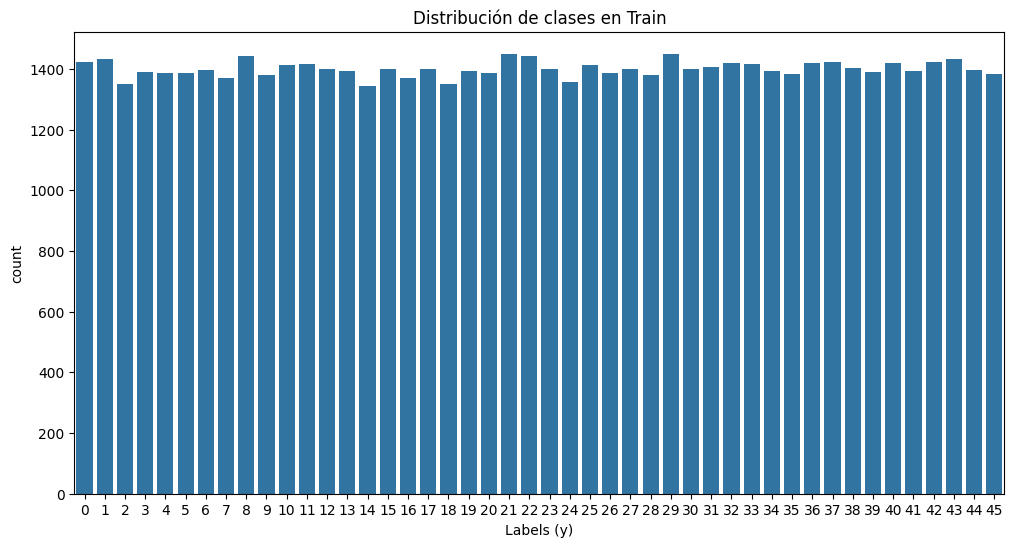

In [16]:
plt.figure(figsize=(12, 6))
sns.countplot(x=Y_train)

plt.title('Distribución de clases en Train')
plt.xlabel(f'Labels (y)')
plt.show()

Como podemos observar, no hay datos que estén _sobrerepresentados_ o _infrarepresentadas_ en nuestro conjunto de training de una manera muy notable o preocupante, por lo que consideramos que con haber hecho una partición de los datos aleatorizada es suficiente para abordar el problema de clases desbalanceadas y por tanto, no haremos procesamiento en cuanto a esto.

#### Transformación del atributo predictor ($y$)

En la construcción de nuestros modelos de clasificación es importante notar que es un problema de clasificación multiclase y no un problema de clasificación binaria, por tanto, tener un enfoque diferente para construir nuestros modelos para que puedan clasificar más de una etiqueta dado un ejemplo.

En primer lugar, para los clasificadores RL y SVM, que son modelos binarios por defecto, usaremos el enfoque denominado _one vs. rest_ que consiste en:

- Para cada etiqueta entrenaremos un modelo (RL y SVM) para predecir de forma binaria si un ejemplo pertenece a tal clase o no; si tenemos $46$ clases entonces comprenderemos $46$ modelos de RL y de SVM.

- Cuando querámos clasificar un ejemplo concreto, cada modelo entrenado para clasificar una etiqueta concreta se aplicará al nuevo ejemplo y elegiremos la clase cuyo modelo ha indicado la mayor pertenencia a tal ejemplo, es decir, tomámos el modelo que ha clasificado con mayor "_confianza_" el ejemplo y tomar la etiqueta que corresponde con tal modelo.

El concepto de pertenencia o _confianza_ en predecir un ejemplo viene dado por el modelo en cuestión; el modelo de RL asigna una probabilidad de _pertenencia_ de un ejemplo a una clase, por tanto podemos usar la misma salida para determinar la mayor pertenencia, esto es, elegir la etiqueta cuyo modelo correspondiente haya dado la mayor probabilidad (el mayor valor $h_i(\text{x})$). El modelo SVM no obstante, clasifica con una función de predicción que asigna la clase a la que pertenece un ejemplo, aún así podemos definir la pertenencia a una clase con la distancia ortogonal del _data point_ con el hiperplano resultante, de esta manera elegimos la clase cuyo modelo SVM correspondiente tenga la mayor distancia con el hiperplano, puesto a que a mayor distancia este el _data point_ del hiperplano más "dentro" esta de la clase a la que pertenece.

Por último, para nuestro modelo de Perceptrón Multicapa no hace falta seguir el mismo enfoque que con RL y SVM ya que este modelo puede tratar con problemas de clasificación multiclase simplemente definiendo la dimensión de la capa de salida como $d(L) = k$ siendo $k$ el número de clases de nuestro problema (sabemos que $k = 46$ para nuestro problema concreto).

Nótese que debemos de realizar una transformación sobre el atributo objetivo de nuestro conjunto de datos, y es el de "binarizar" el atributo, esto es porque nuestros modelos al intentar aprender de nuestros datos, los valores de $y$ que están en el rango $[0,45]$, no tienen una propiedad de orden en ellos; la clase $0$ no es menor que la clase $46$, estos valores de $y_i$ simplemente están para _categorizar_ cada clase $C_i$, por tanto, para poder llevar a cabo el enfoque _one vs. rest_ y definir las etiquetas del MLP, debemos de realizar un tipo de codificación sobre estas categorías. Existen diferentes codificaciones pero nosotros nos valdremos con la de _One Hot Encoding_ que asigna un nuevo atributo por cada categoría (clase); de esta manera nuestro conjunto de etiquetas de training será una matriz $N \times k$, con $N$ el número de ejemplos. Nótese que ahora podemos entrenar un modelo de clasificación binaria simplemente usando una columna de la matriz u otra, además para el modelo MLP será útil ya que ahora podrá aprender la relación de orden existente entre las clases con la "activación" y "desactivación" de cada atributo.

La implementación de este enfoque viene incluido por defecto en los modelos que implementaremos: `SGDClassifier` y `SVC` soportan multiclase con enfoque _One vs. Rest_ (1); sin embargo, aquí hacemos mención del proceso subyacente.

> (1) https://scikit-learn.org/stable/modules/sgd.html#classification

### Extracción de características (_feature extraction_)

#### Problema de la representación de las características $\text{X}$

El último tratamiento sobre los datos que vamos a considerar es acerca del elección y/o extracción de características (_features_) de nuestro conjunto de entrenamiento. Cuando hemos descrito nuestro conjunto de datos de entrada $\text{X} = \{\text{x}_1, \text{x}_2, ..., \text{x}_N\}$, hemos visto que cada vector de características $\text{x}_n$ estaba definido por el conjunto de píxeles del ejemplo concreto (imágen), y cada píxel tenía un valor en el rango $[0,255]$. El problema de estos datos de entrada es que no es un enfoque muy representativo de lo que puede significar un caracter _Devanagari_ y esto puede dar lugar a problemas a nuestros modelos en cuanto a extraer el patrón subyacente en la asignación de las clases.

Por poner un ejemplo, consideremos la clase $C' = \text{"na"}$ que corresponde al caracter _Devanagari_ " __न__ ". Tomamos de esta clase $3$ ejemplos

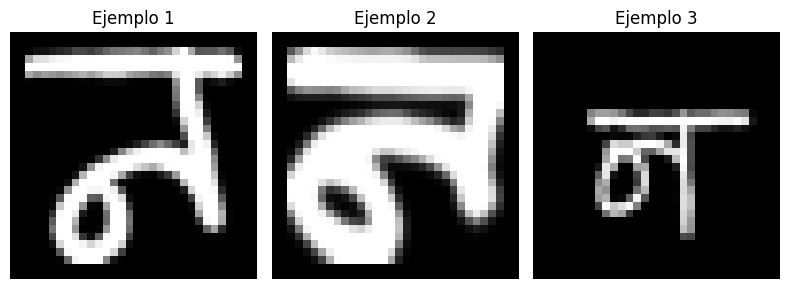

In [17]:
# Obtener la etiqueta para la clase
clas = map_labels['character_20_na']

# Tomar 3 ejemplos
idx_na = Y_train[Y_train == clas][:3]
idx_na = np.argwhere(Y_train == clas).flatten()[:3]

img_arrays = X_train[idx_na]

images = [Image.fromarray(pixels.reshape(32,32).astype(np.uint8)) for pixels in img_arrays]

# PLOT
fig, axes = plt.subplots(1, 3, figsize=(8,6))

for i in range(3):
    # asignar la imagen i al axis i
    axes[i].imshow(images[i], cmap='gray')
    # removemos el axis original para dejar solo la imagen
    axes[i].axis('off')
    axes[i].set_title(f"Ejemplo {i+1}")

# ajustar el espaciado entre las imagenes
plt.tight_layout()

# mostrar plot
plt.show()

Podemos ver que para una misma clase, el estilo de escritura de cada imágen puede diferenciarse notablemente de un ejemplo a otro. Si observamos concretamente el Ejemplo 2 y el ejemplo 3 podemos apreciar una diferencia abismal y es la localización del caracter en la imágen; el Ejemplo 2 abarca una porción de imágen muy alta mientras que el Ejemplo 3 es un caracter mucho más pequeño, esto puede resultar en un empeoramiento del aprendizaje de nuestros modelos por el siguiente motivo: el tamaño de los caracteres no es una característica que queremos aprender de los datos. Si el Ejemplo 1 y 2 abarcan una porción grande de la imágen, el modelo puede aprender, por ejemplo, que los píxeles de la parte superior deben ser blancos, pero cuando se encuentre con un caracter como el Ejemplo 3, detectará que todos los píxeles en la parte superior de la imágen son píxeles negros, por tanto, el modelo clasificará mal el Ejemplo 3 en evaluación y en training dificultaría su aprendizaje.

Esta claro que tenemos, de alguna manera que extraer características representativas de las clases presentes en las imágenes, este proceso como podemos apreciar, no es trivial y de hecho involucra todo un campo en la extracción de características para muchos problemas de ML, lo que se conoce como _feature engineering_. En nuestro caso que trabajamos con caracteres manuscritos, lo único que queremos obtener o extraer de los caracteres son aquellas formas o trazos comunes entre los caracteres de una clase que los diferencian del resto. Por poner el ejemplo anterior, una característica del caracter "_na_" es que "siempre tiene una especie de 'lazo' en la parte izquierda". La representación de estas características es un problema que es complejo sobre todo si queremos representarlas de alguna forma numérica, afortunadamente existen técnicas en la literatura que nos permiten obtener estas características, nosotros optaremos por el método de _Histogram of oriented gradients_ o (HOG).

#### Histogram of Oriented Gradients - HOG

HOG es uno de los muchos descriptores de características para problemas relacionados con Visión por Computador y es usado especialmente para detección de objetos en imágenes.

La idea fundamental de HOG es que las formas de los objetos locales en la imágen (en nuestro caso las formas de los caracteres) pueden ser representados o descritos por una distribución (o histograma) de gradientes de intensidad o direcciones de bordes. La imágen se divide en zonas, llamadas celdas, que comprenden un conjunto de píxeles, se computa luego el histograma de gradientes orientados de cada celda de la imágen; el descriptor final es la concatenación de todos los histogramas de la imágen. Los gradientes sobre una celda obtienen información acerca de la dirección y los cambios de constraste de cada píxel en la celda, estos gradientes pueden ser computados por distintos operadores como Sobel para detección de ejes.

Podemos visualizar un ejemplo de la imágen resultante de usar HOG sobre un caracter concreto (*).

> (*) Este no será la configuración que usaremos, en el ejemplo es solo por motivos ilustrativos y para entender mejor los conceptos.

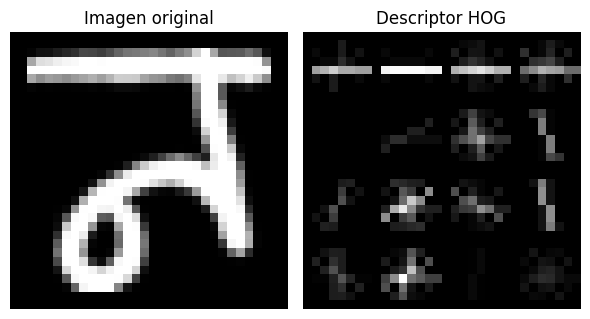

In [18]:
# Cargar una imagen de ejemplo
image = images[0]

# Calculamos el descriptor HOG sobre la imágen
hog_features, hog_image = feature.hog(image, visualize=True)

# Mostrar la imagen original y el resultado del descriptor HOG
fig, axes = plt.subplots(1, 2, figsize=(6, 6))

axes[0].imshow(image, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Imagen original')

axes[1].imshow(hog_image, cmap='gray')
axes[1].axis('off')
axes[1].set_title('Descriptor HOG')

plt.tight_layout()
plt.show()

Como podemos observar, el descriptor logra capturar las diferentes propiedades del caracter:
- Captura la propiedad o característica "_tiene un lazo en la parte izquierda_" y que podemos observar como los gradientes forman un ciclo por la zona izquierda.
- Captura la propiedad "_tiene una barra horizontal superior_" y que podemos observar como los gradientes se orientan horizontalmente en la parte superior del caracter.

En resúmen, HOG nos permite representar características latentes de los caracteres en forma de histogramas de gradientes de intensidad que podemos usar para caracterizar un caracter concreto solo basandonos en estas distribuciones que capturan la esencia del caracter.

HOG es especialmente bueno sobre otros descriptores por centrarse en la distribución de los gradientes en la imágen, por lo que reconoce de una forma más precisa los contornos del objeto en cuestión, algo especialmente útil en nuestro problema para detectar las formas de los caracteres como lazos o formas rectangulares.

Implementaremos el descriptor haciendo uso de la utilidad de `scikit-learn` para extracción de características `hog`. Esta función acepta los siguientes parámetros para ajustar HOG según nuestras necesidades:
- `orientation`: representa la cantidad de orientaciones que tendrá el histograma de gradientes, por tanto, mientras más alto sea el número de orientaciones, será más capaz de capturar contornos más complejos. Aunque puede resultar beneficioso tener un número alto de orientaciones, este aumento también incrementa la dimensión del vector de características resultante, por tanto, es importante encontrar un equilibro para este parámetro; por tanto, asumiremos en un principio el valor por defecto de $9$ orientaciones y ajustaremos el valor según consideremos más adelante.
- `pixels_per_cell`: indica el número de píxeles o el tamaño que tendrá cada celda en la que se divide la imágen. Esta vez, si el tamaño es muy pequeño, el histograma será mucho más preciso para capturar detalles finos, pero esto aumenta la dimensionalidad y por tanto un vector de _features_ mucho más grande. Elegiremos en un principio un valor de `(8,8)` al ser divisor del tamaño de la imágen y por ser un tamaño razonable teniendo en cuenta el tamaño de la imágen original. Esto sin embargo, podemos volver a ajustarlo según necesitemos.
- `cells_per_block`: determina el tamaño de los bloques en los que se normalizan los histogramas locales. La normalización de los histogramas es importante en casos donde se pretende reconocer objetos en imágenes con iluminación por ejemplo, donde la presencia de este puede afectar en las variaciones que pueden tomar los gradientes, esta normalización haría que el descriptor sea más robusto frente a estas variaciones. Este parámetro puede ser útil cuando queremos capturar detalles finos de forma local, por ejemplo, si en los caracteres, es importante determinar bien los trazos de los lazos entonces tener un tamaño de bloque de normalización más grande puede capturar detalles finos al dividirse en más subregiones (celdas), pero esto aumenta también la dimensionalidad del vector resultante; lo contrario pasa el número de celdas por bloques es más pequeño, obteniendo una representación más global. Nosotros, usaremos un tamaño de `(1,1)`, ya que nos conviene ser capaces de capturar detalles más globales de los caracteres, recordemos que el estilo de escritura influye en gran medida, por lo que capturar detalles finos nos puede perjudicar; además estaremos reduciendo dimensionalidad lo que mejora la probabilidad de una mejor generalización.
- `block_norm`: determina el método de normalización que se aplica a cada bloque de normalización de los histogramas. Esto es especialmente relevante cuando las variaciones en la iluminación de las imágenes es muy brusca y por tanto se necesita de un suavizado de estas variaciones para no perjudicar el descriptor. En nuestro caso, como solamente existe una variación monótona en las imágenes, que es cuando se realiza el trazo del caracter, la elección de un método de normalización no es tan relevante, por tanto, nos contentaremos con el valor por defecto `L2-Hys` que simplemente realiza una supresión de los valores atípicos que mejora la invarianza en el contraste.
- `visualize`: indica si se quiere devolver también la imágen resultante del vector de características nuevo. Nosotros indicaremos que `True` solo para fines demostrativos pero en la transformación final no será necesario y estableceremos a `False`.

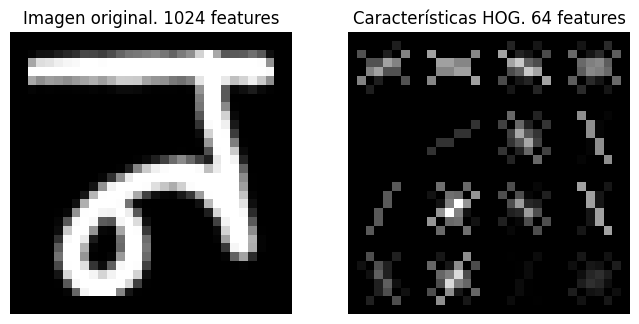

In [19]:
image_pixels = X_train[idx_na[0]].reshape(32,32)

# Calcula el descriptor HOG fd, y devuelve la imagen resultante
fd, image_hog = feature.hog(image_pixels, orientations=4, pixels_per_cell=(8, 8), cells_per_block=(1, 1), block_norm='L2-Hys', visualize=True)

# Visualiza la imagen original y ##la imagen HOG
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image_pixels, cmap=plt.cm.gray)
ax1.set_title(f'Imagen original. {image_pixels.size} features')

ax2.axis('off')
ax2.imshow(image_hog, cmap=plt.cm.gray)
ax2.set_title(f'Características HOG. {fd.size} features')

plt.show()

Como podemos observar, el uso de un tamaño de celdas de $8\times 8$, un tamaño de bloques de $1\times 1$ y un número de orientaciones de $4$ resultan en una reducción considerable del número de características resultante y puede representar relativamente bien un caracter. Esta reducción nos conviene positivamente ya que estamos reduciendo la dimensión VC de nuestro problema y por tanto según la cota de generalización, nuestros modelo generalizarán mejor con nuevos datos, así como mejorar el rendimiento en el proceso de aprendizaje y llegar a una convergencia más temprana.

In [20]:
def extract_features(X):
    # convertir vectores originales en matrices
    X_aux = X.reshape(X.shape[0], 32, 32)

    # por cada ejemplo, obtenemos su respectivo descriptor HOG
    fds = []
    for e in X_aux:
        fd = feature.hog(e, orientations=4, pixels_per_cell=(8, 8), cells_per_block=(1, 1), block_norm='L2-Hys')
        fds.append(fd)

    # devolver el nuevo conjunto de train
    return np.array(fds)

## Proceso de selección de modelos (_model selection_)

#### S-fold Cross Validation
Un aspecto crucial a tener en cuenta y que hemos mencionado antes, es que el conjunto de datos de test $\mathcal D_{test}$ se __reserva__ para la evaluación del modelo __final__, esto quiere decir que el conjunto de test en ningún momento puede influir en el aprendizaje de nuestro modelo, pues _contaminaría_ los datos e introducirían un sesgo en el modelo; por tanto es importante que no utilicemos estos datos hasta el final del entrenamiento cuando queramos evaluar su rendimiento final, ya que el error en este conjunto de test $E_{test}$ resulta en un buen estimador del error fuera de la muestra $E_{out}$ siempre y cuando los datos se hayan obtenido de una muestra identica e independientemente distribuida para poder aplicar la Inecuación de Hoeffding y garantizar una cota del error de generalización que dependa de $E_{test}$, esta cota es mucho menos suelta que la cota de generalización que depende de $E_{in}$ y por tanto es un buen estimador para validar nuestro modelo siempre que se considere solo la hipótesis final $g$ al final del entrenamiento.

Sin embargo, en el ajuste del modelo nos encontraremos en situaciones donde el modelo cambia drásticamente cuando usamos parámetros en los que influye el entrenamiento; estos parámetros son conocidos como _hiperparámetros_ e influyen de una manera significativa el aprendizaje, entre ellos podemos encontrar: el _learning rate_ para el Descenso de Gradiente, el parámetro de penalización o regularización $C$ en el modelo SVM o el parámetro de la intensidad de regularización $\lambda$. Es por esto que debemos de tener alguna forma de evaluar los modelos correspondientes a la elección de los diferentes valores de estos hiperparámetros y poder optar por el mejor de ellos; a este concepto se le denomina elección del modelo o _model selection_. Se trata de poder evaluar _en entrenamiento_ el rendimiento de una serie de modelos cuando se enfrentan con datos __nuevos__, por esto es que usar el propio conjunto de training no es un buen indicador del rendimiento ante datos no vistos por que el modelo esta justamente sesgado por este conjunto, se dice que los datos están _contaminados_. Esto introduce la necesidad de un nuevo conjunto de datos: el conjunto de _validación_.

El conjunto de _validación_ es un conjunto de datos que se extrae realizar un _hold out_ de $\mathcal D_{train}$ y que denominaremos $\mathcal D_{val}$ con tamaño $K$ de ejemplares. Este conjunto de validación es el que se usará para medir el rendimiento de varios modelos en el proceso de _model selection_ mientras que el conjunto de datos restantes se usará para el ajuste. Es importante notar que para definir este conjunto de validación, no es trivial el tamaño $K$ que elegiremos, de hecho la elección de un buen $K$ debe satisfacer por un lado que hayan suficientes ejemplares de entrenamiento $N-K$, y que a la vez satisfaga un $K$ suficiente para que $\mathcal D_{val}$ estime de la mejor manera ek rendimiento fuera de la muestra. Además existe el problema que nos encontramos cuando queriamos separar training y test, que el ajuste depende de la partición concreta del conjunto de datos y puede dar resultados sesgados. Estos problemas los resuelve la técnica que usaremos para poder validar nuestros modelos candidatos, la técnica de validación cruzada en $S$ pliegues o _S-fold cross validation_.

La técnica de validación cruzada en $S$ pliegues o S-fold CV consiste en la partición de los datos de entrenamiento $\mathcal D_{train}$ en $S$ grupos (en nuestro caso nos limitaremos a que los grupos sean del mismo tamaño) y que los $S-1$ groupos se usen para ajustar y el restante se use para validar. Este proceso luego es repetido en todas las $S$ posibles formas de realizar el _hold out_ de $\mathcal D_{train}$. Finalmente, se obtiene el promedio de las mediciones de rendimiento de cada _fold_ y esa será la medición final que mide el rendimiento del modelo. En la siguiente figura(2) podemos observar un esquema visual de la partición tanto de training y test, y la obtención de $S$ conjuntos de validación.

![Esquema de la partición en conjuntos de training, validacion y test](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

Un aspecto a tener en cuenta en esta técnica de _model selection_ es el parámetro $S$ que define tanto $K$ como el número de _folds_ o ajustes y validación a realizar del modelo. Un caso extremo es cuando $S = N$, que es lo que se conoce como _leave-one-out_, ya que ajustamos en cada _fold_ dejando un ejemplo fuera para validación; esta configuración es especialmente útil cuando los datos disponibles son escasos ya que con _leave-one-out_ se consigue el mejor ajuste posible por tener el máximo $N-K$ para entrenar, sin embargo, resulta muy costoso el proceso puesto que si $N$ es muy grande, entonces el número de _folds_ a realizar será muy grande ($N$ _folds_). No hay regla universal para elegir $S$, y en la práctica se suelen usar $S=\{5,10\}$ que son considerados buenas opciones gracias a resultados empíricos(1), nosotros usaremos un $S = 5$ para nuestro problema teniéndo en cuenta que podemos obtener una ganancia de velocidad que si lo hacemos con $S = 10$ que es un aspecto importante ya que estamos usando modelos como MLP que gracias a su arquitectura necesitan mucho tiempo de cómputo para converger.

> (1) Page 184, An Introduction to Statistical Learning, 2013.
>
> (2) https://scikit-learn.org/stable/_images/grid_search_cross_validation.png

In [21]:
def cross_val(model, X, y, folds, score):

    # Crear el objeto K-fold
    kfold = KFold(
        n_splits=folds, # Número de particiones (folds)
        random_state=None, # No establecemos semilla para no conservar un estado concreto y
                           # tener un estado completamente aleatorio
        shuffle=True #Desordenar por clases antes de particionar el conjunto
    )

    # Realizar validación cruzada y devolver los resultados.
    # Especificamos paralelismo de nivel 5 para obtener ganancia en velocidad
    return cross_validate(model, X=X, y=y, cv=kfold, scoring=score, n_jobs=5)

#### Selección de mejores hiperparámetros - _Grid Search_

Ya que tenemos definido la técnica que usaremos para entrenar y evaluar un modelo, pasamos a definir el método que usaremos para elegir la mejor configuración de hiperparámetros para un modelo concreto.

Optaremos en nuestro caso por una técnica ampliamente usada para este tipo de selección y es la técnica de _grid search_. _Grid search_ es una de las muchas técnicas para optimizar hiperparámetros de un modelo, lo que también se denomina _hyperparameter tuning_.

Esta técnica en su versión más simple consiste en entrenar y evaluar un modelo (en nuestro caso usando _Cross Validation_) con una serie de hiperparámetros  tal que cada hiperparámetro tenga un conjunto de valores previamente seleccionados; luego, mediante una búsqueda exhaustiva, se obtienen las métricas de cada una de las posibles combinaciones de hiperparámetros obteniendo finalmente un _ranking_ donde elegiremos la configuración con mejores métricas.

Aunque Grid Search permite obtener la mejor configuración de hiperparámetros, nosotros usaremos _grid search_ de manera individual para cada hiperparámetro, es decir, un proceso de _grid search_ uni-dimensional (_grid_ de solo un hiperparámetro) usando un modelo de base (por ejemplo, usando los hiperparámetros por defecto). De esta manera podemos seleccionar el mejor conjunto de hiperparámetros sin dependencia entre hiperparámetros, es decir, seleccionar los mejores que optimicen un modelo por sí solos.

In [22]:
def single_grid_search_cv(model, X, y, hyper, values, folds, score):
    # Realizamos una copia del modelo para reutilizar el original
    m = clone(model)

    # Busqueda exhaustiva de los valores del hiperparametro
    scores = []
    for v in values:
        # Establecemos el valor del hiperparametro
        params = { hyper: v }
        m.set_params(**params)

        # Evaluamos el modelo
        results = cross_val(m, X, y, folds=folds, score=score)

        # marco el valor concreto del hiperparametro
        results[hyper] = str(v)

        # agregamos los resultados a los globales
        scores.append(results)


    # Devolver el DataFrame con los resultados
    df = pd.DataFrame(scores).drop(columns=['fit_time', 'score_time'])

    # Pongo la columna con el valor del hiperparametro al inicio
    df = df[[df.columns[-1]] + list(df.columns[:-1])]

    return df

#### Selección del mejor modelo

La selección del mejor modelo es el proceso de selección final donde se escogerá el mejor modelo de clasificación $g$ que usaremos posteriormente para la evaluación con el conjunto de test. Primero se obtienen los tres modelos resultantes de haber optimizado sus mejores hiperparámetros y que hemos definido anteriormente con el método _grid search_, estos tres mejores modelos RL, SVM-soft y MLP son los denominados __modelos finalistas__. A continuación, tomaremos los modelos finalistas y les aplicaremos _Cross Validation_ una vez más, obteniendo sus respectivos puntajes; el modelo con puntaje más alto será nuestro modelo final.

El ajuste $g$ final será el resultado de entrenar el mejor modelo con el conjunto de training completo $\mathcal D_{train}$; el error que obtengamos con este $g$ dentro de la muestra es desconocido, sin embargo, sabemos que debe ser menor que $E_{val}$ al ser entrenado con un número mayor de ejemplos, por lo que esto no afecta a nuestra decisión de selección.

#### Modelo de puntaje - _model scoring_

El último apunte acerca del enfoque que seguiremos para el proceso de selección de modelos es el puntaje o _scoring_ que usaremos para evaluar y comparar cada modelo, en efecto, definir nuestro criterio de selección.

Previamente habíamos definido las métricas relevantes que íbamos a usar para poder medir el rendimiento de un modelo, que eran: el _Accuracy_, el _Hamming Loss_ y el _F1-Score_. Aunque pudieramos comprender las tres para evaluar un modelo, lo cierto es que resulta en una tarea muy poco sistemática y poco controlada y manejable, sin embargo, nosotros optaremos por un _score_ mucho más sencillo y que comprende estas tres métricas y es una suma ponderada de estas tres:
$$\alpha_1 \cdot Acc + \alpha_2 \cdot Spec + \alpha_3 \cdot \text{F1}$$

De esta manera, podemos definir los coeficientes $\alpha_i$ según que métricas resultan más importantes o con más peso a la hora de elegir un modelo u otro. Por tanto definiremos estos coeficientes tomándo en cuenta lo siguiente:
- Sabemos que las clases de nuestro conjunto de entrenamiento no tienen algún tipo de desbalanceo importante, por lo que realmente la medición de la _accuracy_ resulta una buena métrica en este caso para comparar los modelos, ya que al estar las clases aproximadamente equitativamente bien representadas entonces un modelo con un _accuracy_ muy alto significa un modelo que está clasificando la mayoría de los ejemplos correctamente y no porque sea una clase mayoritaria. Por tanto, a esta métrica le daremos un peso importante.
- Por otro lado, el F1-Score es una métrica que combina el _Precision_ y el _Recall_ en una sola métrica, por tanto, resulta útil cuando queremos evitar la sobreestimación o subestimación de los errores en la clasificación. En nuestro caso, los errores en clasificación de caracteres manuscritos no son tan relevantes como lo son los aciertos, sobre todo en clasificación multietiqueta donde la clasificación de no pertenencia de una clase es casi una forma de comportamiento por defecto, ya que la gran mayoría de clases responderan negativamente a la pertenencia del ejemplo a ellas y solo una responderá positivamente; por lo que nos interesa elegir un modelo a partir de que tan bien clasifica un ejemplo. Por tanto, al F1-Score tendrá un peso más bien bajo.
- Finalmente, la especificidad mide que tan bien clasifica los casos negativos, en sí el caso es muy similar al de F1-Score, donde nos interesa más premiar los modelos que acierten mejor, por lo que este tendrá un peso muy similar al F1-Score.

Por tanto, podemos asignar unos valores aproximados según las consideraciones de cada métrica con el problema al que nos enfrentamos. Por lo que proporcionamos la siguiente asignación:
$$\text{Score}(h) = 0.7 \cdot Acc(h) + 0.15 \cdot Spec(h) + 0.15\cdot F1(h)$$

Implementamos la función para este _score_ usando los _helpers_ de `scikit-learn` y que aceptan estos parámetros:

- `y_true`: son los valores de salida reales, es decir que es igual a $f(\text{x})$
- `y_pred`: son los valores de predicción del modelo, es decir, $h_{\text{w}}(\text{x})$

Sin embargo, el _specificity_ la sacaremos de la matriz de confusión ya que no viene definida en esta librería

In [23]:
# Creamos una funcion que mida el specificity con la matriz de confusion para clasificacion multietiqueta
def specificity_score_multiclass(y_true, y_pred, class_label):
    # Calcula la matriz de confusión para la clase específica y las demás clases
    true_class = (y_true == class_label)
    predicted_class = (y_pred == class_label)
    TN, FP, FN, TP = confusion_matrix(true_class, predicted_class).ravel()

    # Calcula la especificidad para la clase específica
    specificity = TN / (TN + FP)

    return specificity

def specificity_score(y_true, y_pred, **kwargs):
    # Calcula la especificidad promediada para todas las clases
    num_classes = len(set(y_true))
    specificity_total = 0.0

    # Calculamos el promedio de specificity de cada clase
    for class_label in range(num_classes):
        specificity_total += specificity_score_multiclass(y_true, y_pred, class_label)

    specificity_avg = specificity_total / num_classes
    return specificity_avg

# Creamos una función score customizada
def model_score(y_true, y_pred):
	return 0.7*accuracy_score(y_true, y_pred) + 0.15*specificity_score(y_true, y_pred) + 0.15*f1_score(y_true, y_pred, average='macro')

# Creamos una instancia de la metrica
scorer = make_scorer(model_score)

Este puntaje es el que usaremos para poder evaluar con el criterio mostrado los modelos que se nos presenten.

## Entrenamiento y evaluación de modelos en training

Empezamos entonces a realizar el ajuste, evaluación y comparación de los modelos a disposición para la elección del mejor modelo con el enfoque que hemos descrito anteriormente. El procedimiento lo dividiremos en estos subprocedimientos:
- Tratamiento del conjunto de training con la _pipeline_ de transformaciones y preprocesado.
- Obtención de los modelos finalistas. Elección de mejores hiperparámetros (_grid search_ con _grid_ uni-dimensional para cada parámetro) y selección de mejor técnica de regularización para cada modelo.
- Selección del mejor modelo $g^{*}$. Ajuste final del mejor modelo $g$ con $\mathcal D_{train}$.
- Evaluación del mejor ajuste $g$ con $\mathcal D_{test}$. Preprocesado del conjunto $\mathcal D_{test}$. Obtención de del error $E_{out}$ estimado.

#### Preprocesado del conjunto de train $\mathcal D_{train}$

Realizamos la siguiente _pipeline_ de transformaciones sobre los datos de train para el entrenamiento: escalado y normalización de los datos, obtención del descriptor de características HOG.

La razón por la cual obtendremos los datos normalizados antes de obtener el descriptor HOG es porque, aunque este escalado no se verá reflejado en las _features_ finales, la realidad es que tener un conjunto normalizado de valores hace que la obtención de los gradientes en HOG sea mucho más eficiente y estable, reduciendo la posibilidad de variaciones altas en los valores de las imágenes y dificultando la obtención del descriptor.

Nosotros no realizaremos un escalado de los valores posterior a HOG, esto debido a que HOG realiza una normalización específica para cada atributo, por tanto, no es necesario un reescalado de estos atributos.

In [24]:
# obtenemos los valores máximos y mínimos de las features en training como constantes
MIN_VALUES_TRAIN = X_train.min(axis=0)
MAX_VALUES_TRAIN = X_train.max(axis=0)

# Normalizamos el conjunto de train
X_train_proc = min_max_scaling(X_train, MIN_VALUES_TRAIN, MAX_VALUES_TRAIN)

# Obtenemos el descriptor de caracteristicas HOG como nuestro nuevo conjunto de datos
X_train_proc = extract_features(X_train_proc)

X_train_proc.shape

(64400, 64)

#### Obtención de los modelos finalistas

Teniéndo el conjunto preprocesado y listo para poder ajustar, pasamos a elegir los mejores hiperparámetros. Como hemos dicho, usaremos la técnica de _grid search_ para una búsqueda exhaustiva de los mejores hiperparámetros de forma individual basándonos en un modelo base de prueba, que hemos dicho que serían los modelos por defecto de `scikit-learn`. En el proceso de selección de hiperparámetros por modelo definiremos lo siguiente: el algoritmo de aprendizaje $\mathcal A$ del modelo concreto, regularización a usar y el subconjunto de valores para cada hiperparámetro.

##### __Regresión Logística__

Para el modelo de RL usaremos el algoritmo de optimización _Stochastic Gradient Descent_ o SGD como el algoritmo de aprendizaje $\mathcal A_{RL}$. Elegimos este algoritmo ya que se caracteríza por ser un algoritmo muy rápido y que evita el ajuste del modelo a la muestra de entrenamiento por su carácter estocástico, a diferencia de como pasa con el _Batch Gradient Descent_ convencional. Además, al tomar en cuenta un subconjunto menor de ejemplares por cada iteración, es muy adecuado para datasets muy grandes, como es nuestro caso.

Ahora definimos la regularización a usar, en el que tenemos dos aproximaciones que ofrecen distintas ventajas sobre la otra. Existen dos grandes tipos de regularización los cuales son L1 y L2. Regularización L1 también denominada LASSO, es un tipo de regularización (Least Absolute Shrinkage and Selection Operator) que consiste en la selección automática de los pesos, es decir, lleva implícito reducción de dimensionalidad lo cual ya hemos visto que mejora la generalización del modelo y por tanto funciona como método de regularización. LASSO se basa en la norma L1 (también llamada norma Manhattan) de los coeficientes (pesos) $||\text{w}||_1$, la variable de penalización $\lambda$ implica la reducción de las magnitudes de los coeficientes a $0$, con esto consigue una selección de las características que son importantes para ajustar el modelo; cuando $\lambda$ es mayor entonces la restricción es más fuerte y tiende a una mayor reducción de los pesos. Este método es usualmente elegido cuando la dimensionalidad del problema es muy alto y se requiere de una selección de características para reducir dimensionalidad.
$$\sum_{q=0}^{Q}{|w_q|} \le C$$

Por otro lado, la regularización L2 se basa en la norma L2 también denominada norma Euclídea, que son las sumas de los pesos al cuadrado $||\text{w}||_2$, el detalle del que sea al cuadrado que al aplicar el término de penalización $\lambda$ se penalicen más los coeficientes que son mayores, por lo que consigue lo mismo que L1, que es reducir la dimensionalidad pero de una manera más suave, no tratando todos los coeficientes por igual sino penalizando los que son más altos, esto reduce la complejidad del problema ya que valores altos de $w$ tienden a una clase de funciones $\mathcal H$ más amplia, mientras que si restringimos a valores de $w$ más bajos la clase de funciones se restringe resultando en un $\mathcal H$ mucho más sencillo, además, al priorizar los pesos con menos magnitud se consiguen ajustes muy suaves que evitan el ajuste de ruido (Overfitting). Esta técnica es usada cuando la dimensionalidad del problema no es grave y se sabe que todas las las características son importantes (_feature selection_ menos acusada).
$$\sum_{q=0}^{Q}{w_q^2} \le C$$

En conclusión, L1 (LASSO) es útil cuando se desea realizar una reducción de dimensionalidad porque se sabe (o se sospecha) que hay características irrelevantes. Mientras que L2 es útil para obtener una mejor generalización y se quiere reducir lo máximo posible el Overfitting del modelo mientras se mantienen todas las características (poca reducción). En nuestro caso, el caso de reducir características nos perjudica ya que estaríamos eliminando información importante de un conjunto de atributos que previamente se han extraído mediante un proceso de extracción de características (HOG en nuestro caso), por tanto no tiene mucho sentido usar regularización L1 que sirve mejor cuando se quiere realizar una extracción o selección de características. Por tanto optaremos por usar una regularización L2 (Ridge) que realiza una reducción mucho más suave mientras se consigue la mejor generalización posible.

En cuanto a los hiperparámetros a considerar así como el subconjunto de valores (_grid_) que consideraremos son los que comentaremos a continuación junto con la implementación del clasificador que usaremos. El clasificador que usaremos será la clase de `scikit-learn` `SGDClassifier` que toma los siguientes parámetros e hiperparámetros:
- `eta0` ($\eta_0$): es la tasa de aprendizaje inicial usada en la ecuación general del descenso del gradiente estocástico. Las medidas más usuales para este parámetro son valores menores o iguales que $1$ los cuales podemos considerar $(0.001, 0.01, 0.1)$, estos valores de _learning rate_ suelen ser los más usuales por tener un rendimiento en la práctica muy bueno. Nosotros en este experimento nos limitaremos a que el learning rate sea __constante__ y no dinámico, es decir, $\eta=\eta_0$, por simplicidad en la elección de los distintos parámetros del _grid_ aunque podría ser una opción de cambio si observamos que la función de perdida tiene una forma no convexa más caótica y por tanto requeriríamos de una tasa mucho más compleja.
- `alpha`: es el término de regularización, en nuestro caso L2, y es el parámetro que controla la intensidad de la regularización en el ajuste. En la literatura se le suele denominar $\lambda$. Nosotros usaremos los valores de $(0.01, 0.001, 0.0001)$ ya que valores de $λ$ mayores suelen empeorar la generalización del modelo (1), por tanto consideraremos valores más bien bajos.
- `max_iter`: es el máximo de iteraciones que SGD puede realizar en el entrenamiento. En este caso depende mucho de la cantidad de ejemplos a disposición, como SGD opera aleatoriamente sobre todo el dataset, tenemos que garantizar de alguna manera que se puedan considerar todos los ejemplos. A priori pondremos un solo valor de $20$ iteraciones que podemos ir graduando a nuestro gusto hasta un límite como puede ser, que se cumpla el criterio de parada y no consuma todas las iteraciones, aunque esto será necesario solo si no conseguimos un buen ajuste. La razón de un máximo de épocas tan bajo es por la dimensión de la muestra que contiene un $N$ muy elevado y puede tardar mucho en dar una solución.
- `tol`: es la tolerancia del criterio de parada, es decir, cuando considera el algoritmo que ha convergido; el valor depende del problema en cuestión, si `tol` es muy grande entonces el algoritmo terminará mucho antes mientras que si es muy pequeño, durará más en converger y se necesitará más precisión del algoritmo para que converja. En nuestro caso optarémos por una tolerancia de $10^{-3}$ que parece un valor razonable para poder garantizar cierta precisión en la convergencia del algoritmo.
-`epsilon`: es el umbral de error mínimo. En este caso podemos optar por una error un poco impaciente al principio de $0.1$ y lo iremos bajando hasta que veamos que ya no converge si es necesario, aunque un error aproximadamente de esta magnitud suele ser lo usual.
- `penalty`: indica el tipo de regularización que usaremos, usaremos regularización `'l2'` como hemos dicho antes.
- `loss`: indica la función de perdida. Este parámetro define el modelo concreto de clasificación que usaremos, nosotros especificamos la función de perdida `'log_loss'` que es la función de _Cross Entropy_ que hemos definido anteriormente para RL.
- `shuffle`: Indica si se quiere realizar una aleatorización del conjunto de datos por cada época, para aprovechar las características positivas de la aleatorización en SGD como habíamos comentado, indicaremos un valor de `True` para este parámetro.

> (1) Yaser S. Abu-Mostafa, Malik Magdon-Ismail, and Hsuan-Tien Lin. 2012. Learning From Data. AMLBook. pag 134.

In [25]:
# Definimos los hiperparametros y sus valores así como los parámetros fijos a usar
lrs = [0.001, 0.01, 0.1]
alphas = [0.0001, 0.001, 0.01]
max_iter = 20
tol = 1e-3
epsilon = 0.1

# Definimos un modelo base de RL con valores de hiperparametros por defecto
base_model = SGDClassifier(
    loss='log_loss',
    penalty='l2',
    max_iter=max_iter,
    shuffle=True,
    learning_rate='constant', # Determinar que el learning rate es constante
    tol=tol,
    epsilon=epsilon
)

# Definimos las metricas que usaremos: Accuracy, Specificity, F1-Score, Metrica ponderada
scoring = {
    'accuracy': 'accuracy',
    'specificity': make_scorer(specificity_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro'), # utilizo la opción average='macro' ya que estamos ante un problema
                                                  # de clasificacion multiclase donde las clases estan aprox. equilibradas
                                                  # por lo que se calcula un promedio global sobre las clases sin tener en cuenta
                                                  # el desequilibrio
    'rank_score': scorer
}

# ejecutamos grid search sobre el learning rate inicial
scores = single_grid_search_cv(model=base_model, X=X_train_proc, y=Y_train, hyper='eta0', values=lrs, folds=5, score=scoring)

# obtengo las medias de los resultados
scores_arr = scores.to_numpy()
scores_arr_means = np.array([np.mean(x) for x in scores_arr[:, 1:].flatten()]).reshape(len(lrs),4)
np.hstack((scores_arr[:, 0].reshape(-1,1), scores_arr_means))
scores = pd.DataFrame(np.hstack((scores_arr[:, 0].reshape(-1,1), scores_arr_means)), columns=scores.columns, index=scores.index)

scores

,eta0,test_accuracy,test_specificity,test_f1,test_rank_score
0,0.001,0.671568,0.992702,0.668881,0.719335
1,0.01,0.699596,0.993325,0.697757,0.74338
2,0.1,0.669627,0.99266,0.667082,0.7177


Podemos observar que el _learning rate_ con mejor puntaje es $\eta = 0.01$. Podemos ver también que en cuanto a la especificidad, en todos los casos se tienen valores muy altos, aquí podemos comprobar lo que decíamos acerca de la clasificación negativa de las clases, en el que al ser un problema de clasificación multiclase los verdaderos negativos serán muy altos ya que un ejemplo solo pertenece a una de las $46$ clases existentes. En cuanto al F1-Score podemos observar que obtenemos en la mayoría de los casos un puntaje bueno siendo el mayor aproximadamente $0.7$ de score, esto nos indica que en general estamos obteniendo un modelo con buena precisión y buena exhaustividad (_recall_). Finalmente en cuanto al _accuracy_, en general estamos obteniendo buenas predicciones de nuestro modelo, con casi un $70\%$ de ejemplos bien clasificados en el caso del mejor.

En cuanto al mejor _learning rate_ concluimos que tenemos $0.01$ como mejor tasa de aprendizaje para RL por tener mejor puntaje según nuestro criterio establecido.

Hacemos el mismo experimento pero ahora queriéndo conseguir el mejor término de regularización $λ$. En este caso tenemos que optar por el valor por defecto del _learning rate_, ya que si es constante, debemos de especificar uno concreto, así que dejamos el valor por defecto para que no sea dependiente de un _learning rate_ concreto.

In [26]:
# Definimos un modelo base de RL con valores de hiperparametros por defecto
base_model = SGDClassifier(
    loss='log_loss',
    penalty='l2',
    max_iter=max_iter,
    shuffle=True,
    tol=tol,
    epsilon=epsilon
)

# ejecutamos grid search sobre el término de regularización
scores = single_grid_search_cv(model=base_model, X=X_train_proc, y=Y_train, hyper='alpha', values=alphas, folds=5, score=scoring)

# obtengo las medias de los resultados
scores_arr = scores.to_numpy()
scores_arr_means = np.array([np.mean(x) for x in scores_arr[:, 1:].flatten()]).reshape(len(alphas),4)
np.hstack((scores_arr[:, 0].reshape(-1,1), scores_arr_means))
scores = pd.DataFrame(np.hstack((scores_arr[:, 0].reshape(-1,1), scores_arr_means)), columns=scores.columns, index=scores.index)

scores

,alpha,test_accuracy,test_specificity,test_f1,test_rank_score
0,0.0001,0.713789,0.99364,0.711689,0.755451
1,0.001,0.684938,0.992999,0.681238,0.730592
2,0.01,0.585745,0.990795,0.566104,0.643557


Como podemos observar en los resultados, el $\lambda$ más bajo obtiene una tasa considerablemente mayor de clasificación, esto tiene sentido ya que el error aumentado establece que menores valores de $\lambda$ corresponden a un suavizado de la restricción sobre los pesos
$$E_{aug} = E_{in} + \lambda \text{w}^T\text{w}$$

Por tanto, es esperable que obtenga un error menor si reducimos la intensidad de regularización. Por lo que al mejor $\lambda$ respecta elegiremos el que mayor _rank score_ ha sacado, que es $λ=0.0001$.

##### __SVM-soft__

Ahora evaluaremos y elegiremos los mejores hiperparámetros para el modelo de SVM. Primero definiremos al igual que en RL, el algoritmo de aprendizaje $\mathcal A_{SVM}$ que usaremos; optaremos por usar el algoritmo de programación cuadrática o (QP) que calcula los vectores soporte $\alpha$ que definen el márgen máximo del hiperplano óptimo. Hemos optado por usar este algoritmo por ser menos sensible a la elección de hiperparámetros (como lo es SGD) y por proporcionar una solución exacta para los vectores soportes, a diferencia de nuevo con SGD, el cual es un algoritmo que aproxima a una solución que no se garantiza que sea óptima.

En cuanto al tipo de regularización, al igual que con RL usaremos regularización de tipo L2 (Ridge) por los mismos motivos que con RL, puesto que en este caso queremos realizar una reducción suave y no tan brusca como lo hace L1 ya que consideramos que todos los atributos obtenidos en la extracción de características son igual de importantes. El parámetro de regularización por tanto es la restricción $C$, donde la fuerza o intensidad de regularización es inversamente proporcional a este parámetro. Este parámetro representa la cantidad de errores de clasificación que el ajuste es capaz de tolerar (formulación _soft_) y es el único hiperparámetro que consideraremos para este modelo.

Para la implementación de este modelo usaremos la clase de `scikit-learn` `SVC` (_Support Vector Classifier_), que incluye la regularización L2 y que acepta los siguientes parámetros:

- `C`: es el parametro de penalización o regularización. Nosotros usaremos una lista de estos parámetros razonables para este parámetros que someteremos a una búsqueda _grid search_ $\{0.1, 1.0, 10\}$. A diferencia de SGD donde el parametro de regularización lo manteniamos bajo, en este nos conviene variar entre valor altos y bajos ya que queremos explorar la flexibilidad de nuestro modelo frente a fuertes y flojas restricciones, en este caso, la penalización por error de clasificación. Este será el único hiperparámetro que vamos a tunear con _grid search_.
- `kernel`: especifíca el _kernel_ que usaremos en el algoritmo. El _kernel_ es una función que nos ayuda en la obtención de productos escalares necesarios para la optimización de programación cuadrática desde otro espacio de las muestras, lo que nos permite encontrar un hiperplano más complejo que un simple hiperplano recto. En nuestro caso, estamos considerando a este un modelo no lineal, por tanto elegiremos un _kernel_ radial (RBF) por su capacidad de tratar con problemas de alta dimensionalidad al transformar los datos con NLT, que es muy idóneo para nuestro caso en la que tenemos una gran catidad de dimensiones.
- `gamma`: en nuestro caso que utilizamos un _kernel_ RBF, `gamma` es el parámetro que controla el alcance del _kernel_ al calcular la distancia entre pares vecinos cuando se calculan las RBFs, nosotros optaremos por un valor de autoescala `gamma='scale'` que calcula $\frac{1}{\text{n_features} \times \sigma}$.
- `tol`: es el criterio de parada, similar a caso de SGD en RL, usaremos el valor por defecto de $10^{-3}$
- `class_weights`: podemos asignar pesos a las clases si estas están desbalanceadas; nuestro caso es el contrario, hay un buen balance entre las clases de nuestro conjunto de training, por lo que asignamos un valor de `None`.
- `max_iter`: establece el máximo número de iteraciones del algoritmo. El algoritmo de SVC es un algoritmo muy lento de optimización, por lo que nos convendría, al menos en la selección de hiperparámetros, tener un límite. Por tanto, nosotros usaremos en _grid search_ un valor razonable de `20` iteraciones para elegir el mejor hiperparámetro $C$ y un valor de `-1` para el ajuste del modelo finalista.
- `decision_function_shape`: establece la política de decisión sobre la clasificación de un ejemplo en problemas multiclase. En nuestro caso usaremos la política `One vs Rest` que hemos definido anteriormente.
- `break_ties`: se utiliza para indicar si se quiere "romper empates" entre dos o más clases, en nuestro caso, lo establecemos a `True` para que pueda romper empates usando la función de decisión correspondiente al nivel de confianza en la pertenencia a una clase.

In [27]:
# Definimos los hiperparametros y sus valores así como los parámetros fijos a usar
C_s = [0.1, 1.0, 10]
max_iter = 20
tol = 1e-3

# Definimos las metricas que usaremos: Accuracy, Specificity, F1-Score, Metrica ponderada
scoring = {
    'accuracy': 'accuracy',
    'specificity': make_scorer(specificity_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro'), # utilizo la opción average='macro' ya que estamos ante un problema
                                                  # de clasificacion multiclase donde las clases estan aprox. equilibradas
                                                  # por lo que se calcula un promedio global sobre las clases sin tener en cuenta
                                                  # el desequilibrio
    'rank_score': scorer
}

# Definimos un modelo base de SVC con valores de hiperparametros por defecto
base_model = SVC(
    kernel='rbf',
    gamma='scale',
    tol=tol,
    class_weight=None,
    max_iter=max_iter,
    decision_function_shape='ovr',
    break_ties=True
)

# ejecutamos grid search sobre el término C
scores = single_grid_search_cv(model=base_model, X=X_train_proc, y=Y_train, hyper='C', values=C_s, folds=5, score=scoring)

# obtengo las medias de los resultados
scores_arr = scores.to_numpy()
scores_arr_means = np.array([np.mean(x) for x in scores_arr[:, 1:].flatten()]).reshape(len(C_s),4)
np.hstack((scores_arr[:, 0].reshape(-1,1), scores_arr_means))
scores = pd.DataFrame(np.hstack((scores_arr[:, 0].reshape(-1,1), scores_arr_means)), columns=scores.columns, index=scores.index)

scores

,C,test_accuracy,test_specificity,test_f1,test_rank_score
0,0.1,0.60837,0.991297,0.604645,0.66525
1,1.0,0.712081,0.993602,0.709465,0.753916
2,10,0.741817,0.994263,0.737055,0.778969


In [28]:
# obtengo las medias de los resultados
scores_arr = scores.to_numpy()
scores_arr_means = np.array([np.mean(x) for x in scores_arr[:, 1:].flatten()]).reshape(len(C_s),4)
np.hstack((scores_arr[:, 0].reshape(-1,1), scores_arr_means))
scores = pd.DataFrame(np.hstack((scores_arr[:, 0].reshape(-1,1), scores_arr_means)), columns=scores.columns, index=scores.index)
scores

,C,test_accuracy,test_specificity,test_f1,test_rank_score
0,0.1,0.60837,0.991297,0.604645,0.66525
1,1.0,0.712081,0.993602,0.709465,0.753916
2,10,0.741817,0.994263,0.737055,0.778969


Como podemos observar, un parámetro $C$ mayor es evidentemente más preciso a la hora de clasificar en train. Esto se debe a que al imponer menos restricción (mayor $C$) estamos permitiendo un ajuste menos regularizado, lo que puede ser un signo de Overfitting, sin embargo, al estar usando el error de validación cruzada, tenemos una estimación relativamente buena de $E_{out}$ aunque tiene cierto grado de contaminación, por tanto, como además se indica que $C=10$ es mejor en todas las métricas que los otros parámetros, elegiremos este último como mejor parámetro teniéndo la garantía de que $E_{val} ≈ E_{out}$.

##### __Perceptrón Multicapa__

Por último vamos a definir los elementos de MLP para el proceso de selección de modelos. En primer lugar, el algoritmo de aprendizaje que usaremos $\mathcal A_{MLP}$ será el algoritmo de Backpropagation con _solver_ SGD, este algoritmo de Backpropagation lo hemos elegido por ser un algoritmo muy usado en el entrenamiento de redes neuronales y ser uno de los algoritmos de aprendizaje de redes neuronales más eficientes por su enfoque "hacia atrás" que ha marcado un antes y un después en el desarrollo de estos modelos universales. La hibridación con el algoritmo SGD se refiere a que hace uso de un algoritmo de optimización, en este caso SGD, para optimizar los pesos de la red, mientras que Backpropagation indica las neuronas que más contribuyen al error. Elegimos SGD por las propiedades que hemos explicado en RL que gana en velocidad y generalización.

En cuanto al tipo de regularización, seguiremos optando por la regularización L2 por el mismo motivo de mantener en la medida de lo posible las _features_ que hemos consideradas todas igualmente importantes mientras se consigue una buena generalización. El término de regularización será el mismo que con RL, el parámetro $\lambda$ que indica la intensidad de la regularización de manera proporcional. También utilizaremos una técnica de regularización muy usada en el entrenamiento de redes neuronales que es la técnica de _early stopping_, que consiste, en esencia, controlar el empeoramiento del $E_{out}$ estimado parando el algoritmo cuando se detecta el empeoramiento.

En cuanto a la implementación usaremos la clase de `scikit-learn` `MLPClassifier` que implementa este algoritmo de Backpropagation con diversos algoritmos de optimización. Esta clase acepta los siguientes hiperparámetros:
- `hidden_layer_size`: indica la dimensión de cada capa $d(l)$ de nuestra red, es decir, el número de neuronas por capas. Este parámetro será un hiperparámetro que tendremos que elegir mediante _grid search_ en la cual consideraremos el siguiente subconjunto de valores: $(50, 75, 100)$, donde cada valor indica la dimensión $d(l_i)$ de cada capa.
- `activation`: indica la función de activación de cada neurona; como hemos comentado en la definición de la clase de funciones, usaremos la función de activación ReLU, por tanto especificamos el valor `'relu'` como función de activación.
- `solver`: indica el algoritmo de optimización a usar. Como hemos dicho anteriormente, usaremos el algoritmo o _solver_ SGD para nuestro modelo, por tanto, indicamos el valor `'sgd'`.
- `alpha`: indica el parámetro de regularización que hemos denominado $λ$, este lo consideraremos, al igual que RL, un hiperparámetro que elegiremos mediante _grid search_ y cuyo valores que consideraremos son iguales a los considerados en RL: $(0.01, 0.001, 0.0001)$.
- `batch_size`: indica el tamaño de minibatch que usará el algoritmo de optimización. Esto puede resultar en una ganancia de velocidad al considerar batches de cierto tamaño en vez de ir un ejemplo a la vez. Nosotros usaremos la opción que viene por defecto `auto` que calcula el tamaño como `batch_size=min(200, num_examples)`, que eligirá $200$ ejemplos por minibatch, un tamaño muy razonable para nuestro problema que no penaliza en un ajuste pobre y que ayuda aportando un poco de velocidad al proceso.
- `learning_rate_init`: indica el _learning rate_ inicial, usado en los algoritmos ADAM y SGD. En nuestro caso nosotros consideraremos este parámetro como un hiperparámetro cuyos valores serán los mismo que los que usamos con RL: $(0.1, 0.01, 0.001)$.
- `max_iter`: indica el máximo de épocas o iteraciones en el algoritmo. Al igual que en RL, al ser un dataset de gran dimensionalidad, optaremos por un máximo de iteraciones de $20$ que dan un buen balance con el tiempo de ejecución.
- `shuffle`: indica si se quiere aleatorizar el conjunto de datos por cada época, nosotros indicamos que sí para poder aprovechar las ventajas que provee la estocásticidad en el aprendizaje.
- `random_state`: indica la semilla de números aleatorios. Nosotros no vemos conveniente usar o mantener un estado concreto de randomización, por tanto, especificamos que no.
- `tol`: es el criterio de parada, similar a caso de SGD en RL, usaremos el valor por defecto de $10^{-3}$
- `early_stopping`: indica si se quiere utilizar regularización mediante _early stopping_, como hemos dicho antes lo queremos utilizar, por tanto indicamos que sí.
- `validation_fraction`: indica el tamaño del conjunto de validación para estimar $E_{out}$ en _early stopping_ para determinar el empeoramiento del error fuera de la muestra estimado. Como no queremos perjudicar el aprendizaje quitando muchos ejemplos de entrenamiento, indicaremos una fracción del $10\%$ de los datos (fracción de `0.1`).
- `n_iter_no_change`: indica el máximo número de épocas en la que hay mejora en la tolerancia, esto es un criterio de parada para determinar si se ha convergido finalmente a una solución. Vemos razonable usar un número de $5$ épocas debido al tamaño del dataset en cuestión, la probabilidad de mejora por eṕoca es mayor, por tanto, no es necesario en principio tener este valor muy alto, además de que ganamos en velocidad.

Adicionalmente comentar que la arquitectura que usaremos para nuestra red será una red neuronal de $3$ capas contando la capa de salida, en la implementación mostramos solamente $2$ ya que `MLPClassifier` toma la dimensión de la capa de salida automáticamente del espacio de salida $\mathcal Y$.

In [29]:
# Definimos los hiperparametros y sus valores así como los parámetros fijos a usar
hidden_layers = [(50, 50), (75, 75), (100, 100)]
lrs = [0.1, 0.01, 0.001]
alphas = [0.01, 0.001, 0.0001]

activation = 'relu'
solver = 'sgd'
batch_size = 'auto'
max_iter = 20
tol = 1e-3
validation_fraction = 0.1
n_iter_no_change = 5

# Definimos las metricas que usaremos: Accuracy, Specificity, F1-Score, Metrica ponderada
scoring = {
    'accuracy': 'accuracy',
    'specificity': make_scorer(specificity_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro'), # utilizo la opción average='macro' ya que estamos ante un problema
                                                  # de clasificacion multiclase donde las clases estan aprox. equilibradas
                                                  # por lo que se calcula un promedio global sobre las clases sin tener en cuenta
                                                  # el desequilibrio
    'rank_score': scorer
}

# Definimos un modelo base de MLP con valores de hiperparametros por defecto
base_model = MLPClassifier(
    activation=activation,
    solver=solver,
    batch_size=batch_size,
    max_iter=max_iter,
    tol=tol,
    validation_fraction=validation_fraction,
    n_iter_no_change=n_iter_no_change,
    shuffle=True,
    early_stopping=True,
    random_state=None
)

# ejecutamos grid search sobre el learning rate inicial
scores = single_grid_search_cv(model=base_model, X=X_train_proc, y=Y_train, hyper='learning_rate_init', values=lrs, folds=5, score=scoring)

# obtengo las medias de los resultados
scores_arr = scores.to_numpy()
scores_arr_means = np.array([np.mean(x) for x in scores_arr[:, 1:].flatten()]).reshape(len(lrs),4)
np.hstack((scores_arr[:, 0].reshape(-1,1), scores_arr_means))
scores = pd.DataFrame(np.hstack((scores_arr[:, 0].reshape(-1,1), scores_arr_means)), columns=scores.columns, index=scores.index)

scores

,learning_rate_init,test_accuracy,test_specificity,test_f1,test_rank_score
0,0.1,0.801879,0.995598,0.801372,0.830861
1,0.01,0.72368,0.99386,0.721992,0.763954
2,0.001,0.523323,0.989408,0.505197,0.590517


Observamos con la evaluación del _learning rate_ inicial, que al igual que con RL, la mejor tasa de aprendizaje sigue siendo el $\eta=0.01$, además con métricas muy similares a las de RL; esto tiene sentido ya que ambos modelos hacen uso de la misma función de perdida, la _Cross Entropy_, luego es lógico que obtienen el mismo espacio de búsqueda y por eso se asemejan tanto. Por tanto, al igual que con RL elegimos como tasa de aprendizaje $\eta=0.01$ que es el que mayor _rank score_ obtiene.

In [30]:
# ejecutamos grid search sobre el termino de regularización
scores = single_grid_search_cv(model=base_model, X=X_train_proc, y=Y_train, hyper='alpha', values=alphas, folds=5, score=scoring)

# obtengo las medias de los resultados
scores_arr = scores.to_numpy()
scores_arr_means = np.array([np.mean(x) for x in scores_arr[:, 1:].flatten()]).reshape(len(alphas),4)
np.hstack((scores_arr[:, 0].reshape(-1,1), scores_arr_means))
scores = pd.DataFrame(np.hstack((scores_arr[:, 0].reshape(-1,1), scores_arr_means)), columns=scores.columns, index=scores.index)

scores

,alpha,test_accuracy,test_specificity,test_f1,test_rank_score
0,0.01,0.518711,0.989305,0.499378,0.5864
1,0.001,0.512811,0.989174,0.492962,0.581288
2,0.0001,0.521599,0.989369,0.504166,0.58915


En cuanto al término de regularización, vemos que los valores son muy similares entre sí, veamos que ocurre si usamos valores mas extremos en cambio para determinar si es que el modelo es insensible a estos cambios o tenemos que aumentar el espacio de búsqueda.

In [31]:
# ejecutamos grid search sobre el termino de regularización
alphas = [0.00001, 0.1, 1]
scores = single_grid_search_cv(model=base_model, X=X_train_proc, y=Y_train, hyper='alpha', values=alphas, folds=5, score=scoring)

# obtengo las medias de los resultados
scores_arr = scores.to_numpy()
scores_arr_means = np.array([np.mean(x) for x in scores_arr[:, 1:].flatten()]).reshape(len(alphas),4)
np.hstack((scores_arr[:, 0].reshape(-1,1), scores_arr_means))
scores = pd.DataFrame(np.hstack((scores_arr[:, 0].reshape(-1,1), scores_arr_means)), columns=scores.columns, index=scores.index)

scores

,alpha,test_accuracy,test_specificity,test_f1,test_rank_score
0,1e-05,0.523975,0.989422,0.505739,0.591057
1,0.1,0.516165,0.989249,0.497064,0.584262
2,1,0.491165,0.988693,0.465422,0.561933


Vemos que cuando empezamos a incrementar los valores de $\lambda$ tenemos peor _rank score_, mientras que pasa al revés cuando decrementamos. Esto se debe a que cuando aumentamos el $\lambda$ estamos restringiendo más los valores de los pesos y por tanto regulariza más, mientras que si decrementamos $\lambda$ estamos dando mucha más libertad a estos valores. Sin embargo, es interesante notar que si decrementamos el valor de $\lambda$ en un factor de $10$, tenemos resultados muy similares a cuando no decrementabamos, en este caso $Score(\lambda = 0.0001) \approx Score(\lambda=0.00001)$, esto puede ser un signo de convergencia. En este caso optamos por el valor más alto de regularización que es $\lambda = 0.0001$.

In [32]:
# ejecutamos grid search sobre las dimensiones de las capas
scores = single_grid_search_cv(model=base_model, X=X_train_proc, y=Y_train, hyper='hidden_layer_sizes', values=hidden_layers, folds=5, score=scoring)

# obtengo las medias de los resultados
scores_arr = scores.to_numpy()
scores_arr_means = np.array([np.mean(x) for x in scores_arr[:, 1:].flatten()]).reshape(len(hidden_layers),4)
np.hstack((scores_arr[:, 0].reshape(-1,1), scores_arr_means))
scores = pd.DataFrame(np.hstack((scores_arr[:, 0].reshape(-1,1), scores_arr_means)), columns=scores.columns, index=scores.index)

scores

,hidden_layer_sizes,test_accuracy,test_specificity,test_f1,test_rank_score
0,"(50, 50)",0.484037,0.988535,0.468447,0.557373
1,"(75, 75)",0.539829,0.989774,0.531337,0.606047
2,"(100, 100)",0.567081,0.99038,0.559106,0.629379


Por último, la evaluación de las dimensiones de cada capa de la red que hemos considerado, podemos ver que cuando aumentamos la dimensión de las capas se obtiene una mejora con respecto a una dimensión mucho más simple; esto se debe a que, al agregar más neuronas por capa, la red es capaz de capturar propiedades no lineales más complejas. Por tanto, optamos por elegir una dimensión por capa oculta de $d(l_i) = 100,\ \ i = \{1, 2\}$.

#### Obtención del mejor modelo $g$

Teniéndo los modelos finalistas resultantes de elegir los mejores hiperparámetros elegidos mediante _grid search_, elegiremos el mejor modelo evaluando cada finalista y obteniendo sus _rank scores_.

In [33]:
tol = 1e-3
# Definimos los finalistas
best_rl = SGDClassifier(
    eta0=0.01,
    alpha=0.0001,
    loss='log_loss',
    penalty='l2',
    max_iter=20,
    shuffle=True,
    learning_rate='constant', # Determinar que el learning rate es constante
    tol=tol,
    epsilon=0.1,
    random_state=33
)
best_svm = SVC(
    C=10,
    kernel='rbf',
    gamma='scale',
    tol=tol,
    class_weight=None,
    max_iter=20,
    decision_function_shape='ovr',
    break_ties=True
)
best_mlp = MLPClassifier(
    hidden_layer_sizes=(100,100),
    learning_rate_init=0.1,
    alpha=0.0001,
    activation=activation,
    solver=solver,
    batch_size=batch_size,
    max_iter=50,
    tol=tol,
    validation_fraction=validation_fraction,
    n_iter_no_change=n_iter_no_change,
    shuffle=True,
    early_stopping=True,
    random_state=33
)

In [34]:
# Evaluamos los modelos y obtenemos sus métricas
scores_rl = cross_val(best_rl, X_train_proc, Y_train, 5, scoring)
scores_svm = cross_val(best_svm, X_train_proc, Y_train, 5, scoring)
scores_mlp = cross_val(best_mlp, X_train_proc, Y_train, 5, scoring)

print('RL Rank Score:', scores_rl['test_rank_score'])
print('SVM Rank Score:', scores_svm['test_rank_score'])
print('MLP Rank Score:', scores_mlp['test_rank_score'])


RL Rank Score: [0.74802375 0.73708461 0.74366926 0.74072947 0.75132299]
SVM Rank Score: [0.77833834 0.77382447 0.77950218 0.78065884 0.77757346]
MLP Rank Score: [0.84597653 0.84650869 0.84574352 0.84475282 0.83443229]


In [35]:
print('RL Rank Score:', scores_rl['test_rank_score'].mean())
print('SVM Rank Score:', scores_svm['test_rank_score'].mean())
print('MLP Rank Score:', scores_mlp['test_rank_score'].mean())

RL Rank Score: 0.7441660157653729
SVM Rank Score: 0.7779794588213709
MLP Rank Score: 0.8434827687379289


Como podemos observar, el modelo que ha obtenido mejor _rank score_ ha sido el modelo del Perceptrón Multicapa con un puntaje medio de $0.84$, por tanto, según nuestro criterio de selección nuestro mejor modelo $g^*$ es el de MLP para nuestro problema de clasificación de dígitos.

A continuación, realizamos un ajuste final sobre todo el conjunto de training para obtener el ajuste de la mejor hipótesis $g$ al problema.

In [36]:
best_model = best_mlp
best_model.fit(X_train_proc, Y_train)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(100, 100),
              learning_rate_init=0.1, max_iter=50, n_iter_no_change=5,
              random_state=33, solver='sgd', tol=0.001)

#Evaluación del Modelo Final

A continuación pasaremos a evaluar nuestro ajuste $g$ con el conjunto que hemos reservado de test. Procederemos primero a transformar el conjunto de test con las mismas transformaciones que hicimos para el de train.

In [37]:
# Normalizamos el conjunto de train
X_test_proc = min_max_scaling(X_test, MIN_VALUES_TRAIN, MAX_VALUES_TRAIN)

# Obtenemos el descriptor de caracteristicas HOG como nuestro nuevo conjunto de datos
X_test_proc = extract_features(X_test_proc)

X_test_proc.shape

(27600, 64)

Ahora sí procedemos a evaluar nuestro modelo con el conjunto de test preprocesado y obtenemos sus métricas así como el error $E_{test}$ que estima $E_{out}$.

In [38]:
y_pred = best_model.predict(X_test_proc)

# Creamos los scorers para adaptarlos a multiclase
spec_scorer = make_scorer(specificity_score, average='macro')

acc = accuracy_score(y_true=Y_test, y_pred=y_pred)
spec = specificity_score(y_true=Y_test, y_pred=y_pred)
f1 = f1_score(y_true=Y_test, y_pred=y_pred, average='macro')

y_pred_proba = best_model.predict_proba(X_test_proc)
loss = log_loss(Y_test, y_pred_proba)

print('Acc_test:', acc)
print('Spec_test:', spec)
print('F1_test:', f1)
print('Error de test (Función de Pérdida Loss_test):', loss)


Acc_test: 0.822463768115942
Spec_test: 0.9960542216038847
F1_test: 0.8223799883976881
Error de test (Función de Pérdida Loss_test): 0.6169379768818682


Como podemos observar, la solución final ha obtenido un buen error en test y buenos resultados en las metricas por lo que podemos afirmar que hemos obtenido un buen clasificador y unos buenos resultados (sin provocar overfitting por parte del modelo no lineal)

##Curvas de aprendizaje

Vamos a crear las curvas de aprendizaje del modelo elegido separando de nuevo el conjunto de entrenamiento en un nuevo conjunto de validación del 20% y otro conjunto de entrenamiento del 80%, de forma parecida a como se hizo con el conjunto total de datos. Después voy a entrenar el modelo con un conjunto de datos inicialmente pequeño y obtengo el error de validación junto con el de entrenamiento, y cada iteración repito lo mismo pero con un subconjunto de datos mayor obtenido del conjunto de entrenamiento hasta utilizar el conjunto de datos total. Finalmente se crean las curvas de los errores $E_{in}$ de entrenamiento y $E_{out}$ estimado a partir del error obtenido del conjunto de validación.

Debido al alto coste computacional de entrenar varias veces el modelo con conjuntos de entrenamiento distintos, hemos utilizado un número bajo de entrenamientos y particiones del conjunto de entrenamiento para que no tarde en exceso en caclular las curvas de aprendizaje, entonces las curvas tienen poca desnidad de puntos, pero si se aumenta el numero de particiones (la variable `numiters` en el código), se consiguen curvas de aprendizaje con más densidad de puntos.

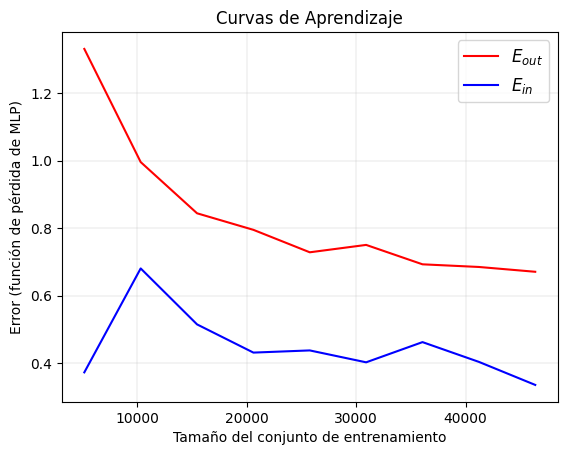

In [39]:
np.random.seed(0)
trainPortion = 0.8 #porcentaje de train, el porcentaje de validacion será la resta de 1 menos el porcentaje de train
indexesData = np.arange(len(Y_train)) #Indices del conjunto de muestras
np.random.shuffle(indexesData) #Desordenar indices de las muestras
numberTrain = round(len(indexesData)*trainPortion) #numero de muestras para train
trainIndexes = indexesData[:numberTrain]
valIndexes = indexesData[numberTrain:]

E_in = []
E_out = []
ejeX = []
numiters = 10
for i in range(1,numiters):
  ejeX.append(i*len(trainIndexes)//numiters)
  # Entrenar el modelo con los datos de entrenamiento
  best_model.fit(X_train_proc[trainIndexes[:i*len(trainIndexes)//numiters]], Y_train[trainIndexes[:i*len(trainIndexes)//numiters]])
  # Obtener error en entrenamiento
  y_pred_proba = best_model.predict_proba(X_train_proc[trainIndexes[:i*len(trainIndexes)//numiters]])
  E_in.append(log_loss(Y_train[trainIndexes[:i*len(trainIndexes)//numiters]], y_pred_proba))
  # Obtener error en validación
  y_pred_proba = best_model.predict_proba(X_train_proc[valIndexes])
  E_out.append(log_loss(Y_train[valIndexes], y_pred_proba))

# Mostrar plot con ambas curvas
plt.figure()
plt.title("Curvas de Aprendizaje")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Error (función de pérdida de MLP)")
plt.plot(ejeX, E_out, 'r',label=r'$E_{out}$')
plt.plot(ejeX, E_in, 'b',label=r'$E_{in}$')

plt.legend(fontsize = 12) # poner el tamaño de la leyenda como en el resultado dado
plt.grid(visible=True,linewidth=0.2) # poner la cuadricula con el grosor del resultado dado

plt.show()

Podemos observar en el gráfico de las curvas de aprendizaje que el modelo se comporta de forma correcta ajustandose al problema y obteniendo una buena generalización a medida que aumenta el tamaño del conjunto de muestras. Cuantos más datos se usan para entrenar el modelo, más generalización se consigue (al tener más información del problema y de la función objetivo) y por tanto el error $E_{out}$ se acerca cada vez más al error $E_{in}$. El modelo es capaz de ajustar mejor los datos cuantos menos muestras haya, ya que al haber menos datos, el modelo tiene que predecir menos muestras y entonces puede ajustarse mejor a una cantidad menor de datos, por lo tanto el error $E_{in}$ aumenta con el tamaño del conjunto de entrenamiento. En la curva de aprendizaje que obtenemos se ve esto al principio como el error $E_{in}$ aumenta al umentar el tamaño del conjunto pero despues sigue estable. Por otro lado, cuantos más muestras se tienen, más información se tiene del problema y por tanto se puede obtener una mayor generalización de la función objetivo obteniendo un error $E_{out}$ menor a medida que aumenta el tamaño del conjunto de muestras. Es por esto que los errores $E_{in}$ y $E_{out}$ tienden a acercarse y converger a medida que aumenta el tamaño del conjunto de entrenamiento.
A partir de estos resultados podemos establecer que este modelo ha conseguido ajustarse bien al problema consiguiendo generalizar la función objteivo, como osbervarmos en la disminución del error $E_{out}$ a medida que aumenta el tamaño del conjunto de entrenamiento, ya que cuanta más información se le ofrece al modelo para entrenar, mejoes resultados y error $E_{out}$ obtiene y por tanto más aprende.

##Conclusión

En esta práctica hemos utilizado diversos modelos para tratar de ajustar un problema con un conjunto de datos asociado para obtener un clasificador final óptimo comparando entre los modelos utilizados. En concreto hemos utilizado un modelo lineal y dos modelos no lineales. El modelo lineal escogido ha sido Regresión Logística empleado mediante SGD, y los dos modelos no lineales escogidos han sido Perceptrón Multicapa empleando SGD para su entrenameinto y SVM Soft, como se ha explicado al principio. Tras evaluar los modelos junto con diversos valores de hiperparámetros de cada uno, hemos comparado sus resultados utilizando la técnica de Cross Validation con un Fold de 5 y hemos elegido el mejor modelo basándonos en los resultados de las métricas que hemos elegido para comparar los modelos. Finalmente hemos evaluado el modelo entrenado con todo el conjunto de entrenamiento a la hora de predecir las muestras del conjunto de test y hemos analizado los resultados obtenidos.

 Por el proceso que hemos seguido para obtener el modelo final, la solución final obtenida es el mejor resultado posible que hemos obtenido para la muestra dada, ya que en primer lugar hemos elegido los modelos específicos mejores las propiedades del problema, hemos elegido las métricas también acorde con las características de la base de datos de la que disponíamos junto con las funciones de pérdida para los algoritmos de aprendizaje, hemos utilizado técnicas como Cross Validation para obtener una comparación precisa entre los modelos y elegir los hiperparámetros adecuados y finalmente hemos comprobado que la solución final se ajusta correctamente al problema, obteniendo el error $E_{out}$ y los resultados de las métricas sobre el conjunto de test que nos indican que hemos obtenido una buena solución, y obteniendo las curvas de aprendizaje que nos indican la buena generalización que ha obtenido el modelo para este problema con este conjunto de muestras.